# Exemple pràctic sobre els punts principals a considerar en un experiment basat en dades 

## Introducció

Aquest Notebook vol reflectir, a grans trets, el procés a realitzar per entrenar un model d'aprenentatge automàtic.
Les dades disponibles consisteixen per cada 15 minuts el nombre de vehicles que creuen diferents punts de mesura de la ciutat de Barcelona durant l'any 2019. 
Concretament, ens centrarem en un punt específic situat a l'entrada de la Diagonal (AV. DIAGONAL - TORRE MELINA).

**Intensitat: nombre de vehicles que creuen el punt de mesura durant 1 hora.**


## Objectiu

L'objectiu consisteix a predir el nombre de cotxes que passaran pel punt de mesura seleccionat cada hora pels següents 7 dies. **Tipologia del problema: sèries temporals.**

## Fase 0: Constants

Inicialització de les variables necessàries per a l'execució correcta del Notebook.


## Fase 1: Extracció de les dades
### Dades

### 1.1. measuring_points.csv 
Punts de mesura de la ciutat de Barcelona i de les Rondes.

| columna | descripció | format | 
| ------- | ---------- | ------ |
| id      | identificador únic del punt de mesura | string |
|description | carrer en que està situat el punt de mesura |  string |
|measuring_point_type | tipologia del sensor | string |
|lanes_number| nombre de  carrils d'on està situat el punt de mesura | numèric |
|measurement_system | tecnologia del sensor | string |
|coordinates | coordenades del punt de mesura | string |

### 1.2. measurements.csv 
Nombre de cotxes que passen per cada un dels punts de mesura cada 15 minuts.

| columna | descripció | format | 
| ------- | ---------- | ------ |
| id      | identificador únic de la mesura | string |
| measuring_point_id| identificador únic del punt de mesura | string | 	
| timestamp | data i hora de la mesura | data |
| day_type | tipologia de dia | string |
| intensity | nombre de vehicles que han creuat el punt de mesura | numèric |

## Fase 2: Anàlisis i neteja de les dades

En aquesta fase, s'analitzaran els dos fitxers de dades per treure'n indicadors útils. Addicionalment, també es netejaran les dades i es crearà el dataset necessari per entrenar els models.

## Fase 3: Models

### 3.1 Separació train - test de les dades

Per entrenar el model, es faran servir 8 setmanes per l'entrenament i 1 setmana de test.

### 3.2 Entrenament dels models

És provaran dos models SARIMAX:
- amb estacionalitat diària
- amb estacionalitat setmanal

### 3.3 Evaluació dels models

S'avaluarà quin dels models provats funciona millor.

In [1]:
import sys
sys.path.append('../')

In [2]:
import os 

import numpy as np
import pandas as pd

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import plotly.graph_objects as go
import seaborn as sns

from src import visualizations, timeseries
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

pd.options.mode.chained_assignment = None

## Fase 0: Constants

In [3]:
data_folder = os.path.join('..', 'data')

measuring_points_file_path = os.path.join(data_folder, "measuring_points.csv")
measurements_file_path = os.path.join(data_folder, "measurements.csv")

measuring_point_columns = [
    'id',
    'description',
    'measuring_point_type',
    'lanes_number',
    'measurement_system',
    'coordinates'
]

selected_mp = '1001'

## Fase 1: Extracció de les dades

#### En aquest pas carreguem els fitxers de dades a memòria per analitzar-los.

In [4]:
measuring_points_df = pd.read_csv(
    measuring_points_file_path, usecols=measuring_point_columns)

print(f'measuring_points_df.shape: {measuring_points_df.shape}\n')
measuring_points_df.head()

measuring_points_df.shape: (698, 6)



id                      description measuring_point_type  lanes_number  \
0  10001        ARAGÓ - NAVAS (Llobregat)              Trànsit             2   
1  10002   BAC DE RODA - BOLIVIA (Pujada)              Trànsit             3   
2  10005           ARAGÓ - BILBAO (Besòs)              Trànsit             2   
3  10008   CANTÀBRIA - GUIPÚSCOA (Pujada)              Trànsit             2   
4  10009  GUIPÚSCOA - MARESME (Llobregat)              Trànsit             2   

  measurement_system                        coordinates  
0             Espira  41.4116798138391,2.19073536914761  
1             Espira  41.4113366439258,2.19898280387419  
2             Espira  41.4122858738082,2.19188571810162  
3             Espira  41.4200433612197,2.20106339805483  
4             Espira  41.4209259389645,2.20302142326192

In [5]:
measurements_df = pd.read_csv(
    measurements_file_path, parse_dates=['timestamp'], 
    dtype={'measuring_point_id': str}) \
    .drop(columns=['duplicated_row'])

print(f'measurments_df.shape: {measurements_df.shape}\n')
measurements_df.head()

measurments_df.shape: (12955710, 5)



id measuring_point_id           timestamp  \
0  10001-20190101000000              10001 2019-01-01 00:00:00   
1  10001-20190101001500              10001 2019-01-01 00:15:00   
2  10001-20190101003000              10001 2019-01-01 00:30:00   
3  10001-20190101004500              10001 2019-01-01 00:45:00   
4  10001-20190101010000              10001 2019-01-01 01:00:00   

             day_type  intensity  
0  Domingo y Festivos         36  
1  Domingo y Festivos         98  
2  Domingo y Festivos        279  
3  Domingo y Festivos        237  
4  Domingo y Festivos        313

## Fase 2: Anàlisis i neteja de les dades

En aquest punt analitzarem cada conjunt de dades, per poder extreure'n indicadors que ens donin informació rellevant 

1. Punts de mesura
2. Mesures

### 2.1. Punts de mesura

Primer de tot mirem per cada variable quantes dades tenim sense informar

In [6]:
cond_measuring_point_type = \
    measuring_points_df.measuring_point_type == "Rondes"

grouped_df = measuring_points_df \
    .groupby("measuring_point_type").size().sort_values(ascending=False) \
    .reset_index() \
    .rename(columns={0: "num"})

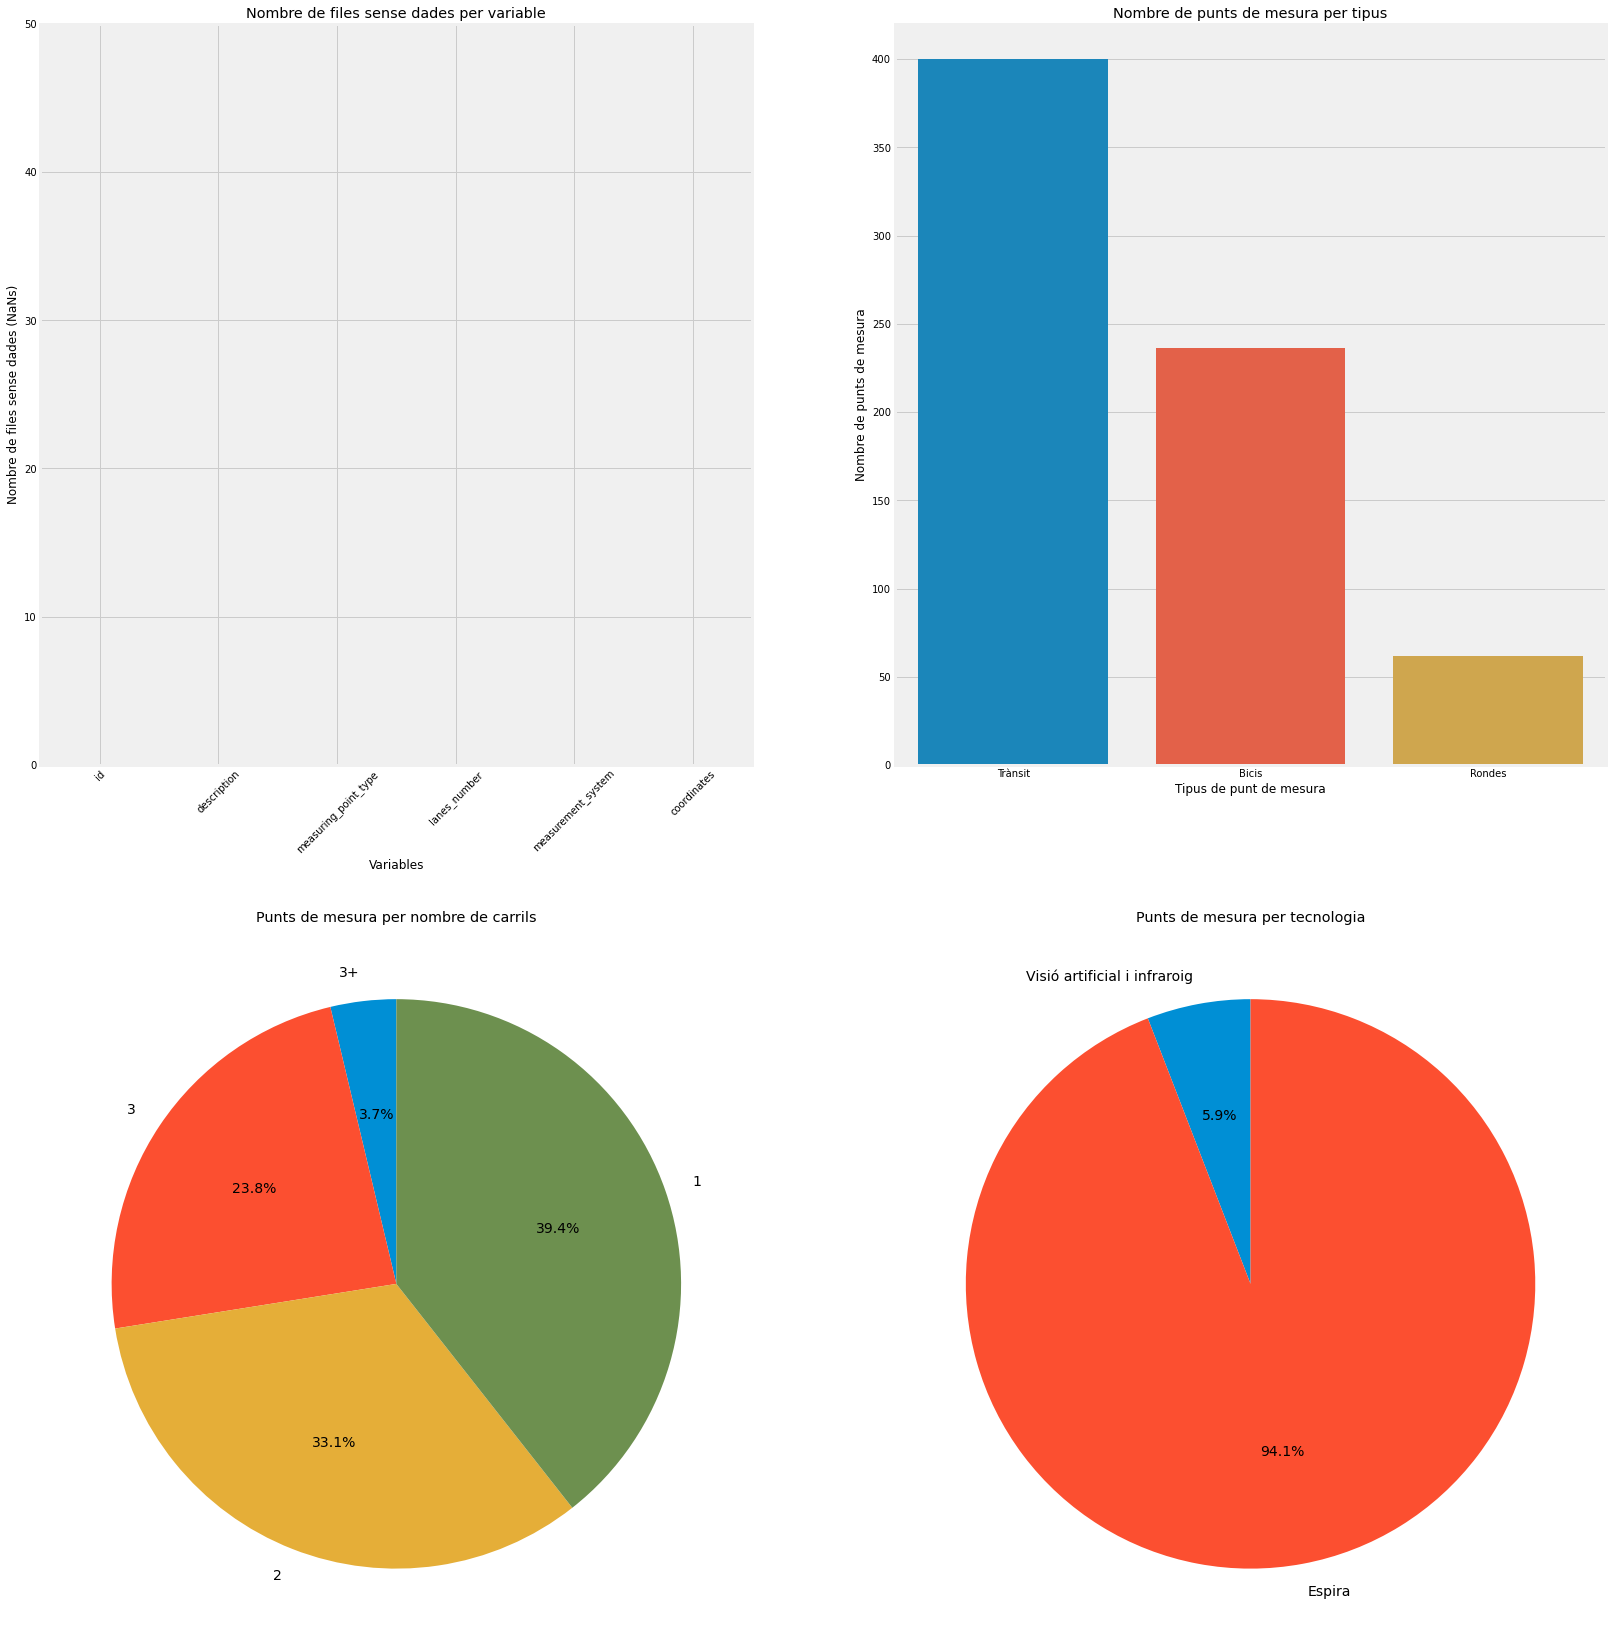

In [7]:
fig = plt.figure(figsize=(25, 30))

ax1 = fig.add_subplot(221)
_ = measuring_points_df \
    .isnull().sum() \
    .sort_values(ascending=False) \
    .plot(kind="bar", xlabel="Variables", rot=45, ax=ax1,
          ylabel="Nombre de files sense dades (NaNs)",
          title="Nombre de files sense dades per variable")
_ = ax1.set_ylim((0, 50))

ax2 = fig.add_subplot(222)
_ = sns.barplot(
    x="measuring_point_type", y="num", data=grouped_df, ax=ax2)
_ = ax2.set_title("Nombre de punts de mesura per tipus")
_ = ax2.set_xlabel("Tipus de punt de mesura")
_ = ax2.set_ylabel("Nombre de punts de mesura")

ax3 = fig.add_subplot(223)
title = "Punts de mesura per nombre de carrils"
visualizations.create_pie_chart_with_grouped_threshold(
    measuring_points_df, "lanes_number", grouped_label="3+", 
    ax=ax3, title=title, threshold=0.1)

ax4 = fig.add_subplot(224)
title = "Punts de mesura per tecnologia"
grouped_label = "Visió artificial i infraroig"
visualizations.create_pie_chart_with_grouped_threshold(
    measuring_points_df, "measurement_system", grouped_label=grouped_label, 
    ax=ax4, title=title, threshold=0.1)

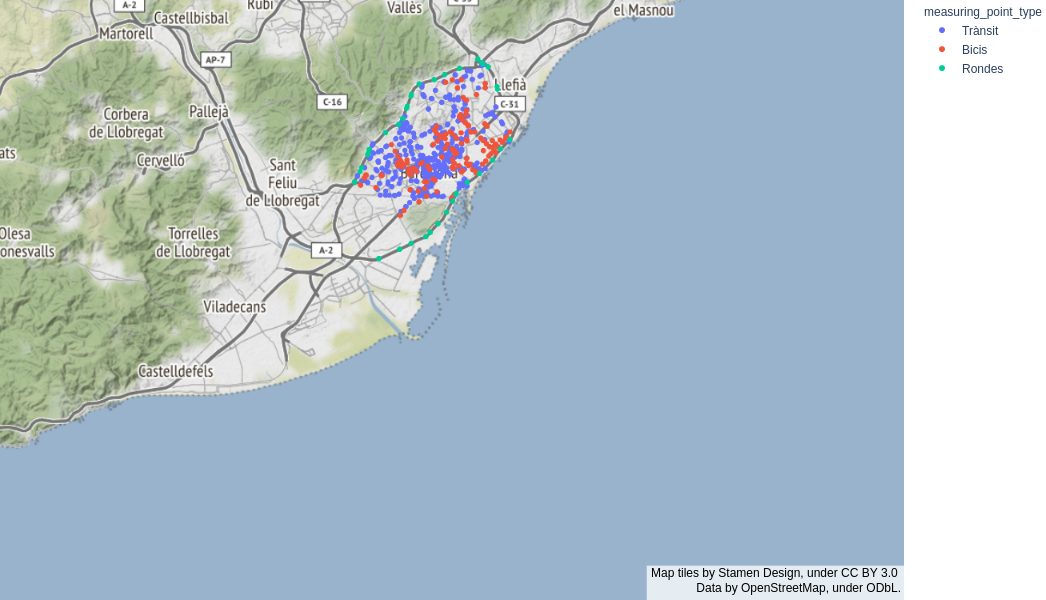

In [8]:
visualizations.plot_measuring_points(
    measuring_points_df.copy(), coordinates_column='coordinates', 
    color_column='measuring_point_type')

### 2. Mesures

Primer de tot ajuntem el conjunt de dades dels punts de mesura i de les mesures

In [9]:
measuring_points_df.rename(columns={"id": "measuring_point_id"}, inplace=True)

df = pd.merge(
    measurements_df, measuring_points_df, how="left", on="measuring_point_id")

print(f"df.shape: {df.shape}")
df.head()

df.shape: (12955710, 10)


id measuring_point_id           timestamp  \
0  10001-20190101000000              10001 2019-01-01 00:00:00   
1  10001-20190101001500              10001 2019-01-01 00:15:00   
2  10001-20190101003000              10001 2019-01-01 00:30:00   
3  10001-20190101004500              10001 2019-01-01 00:45:00   
4  10001-20190101010000              10001 2019-01-01 01:00:00   

             day_type  intensity                description  \
0  Domingo y Festivos         36  ARAGÓ - NAVAS (Llobregat)   
1  Domingo y Festivos         98  ARAGÓ - NAVAS (Llobregat)   
2  Domingo y Festivos        279  ARAGÓ - NAVAS (Llobregat)   
3  Domingo y Festivos        237  ARAGÓ - NAVAS (Llobregat)   
4  Domingo y Festivos        313  ARAGÓ - NAVAS (Llobregat)   

  measuring_point_type  lanes_number measurement_system  \
0              Trànsit             2             Espira   
1              Trànsit             2             Espira   
2              Trànsit             2             Espira   
3              Trànsit             2             Espira   
4              Trànsit             2             Espira   

                         coordinates  
0  41.4116798138391,2.19073536914761  
1  41.4116798138391,2.19073536914761  
2  41.4116798138391,2.19073536914761  
3  41.4116798138391,2.19073536914761  
4  41.4116798138391,2.19073536914761

In [10]:
print(f'Data inici {df.timestamp.min()}')
print(f'Data fí {df.timestamp.max()}')

Data inici 2019-01-01 00:00:00
Data fí 2019-12-31 23:45:00


Podem veure per tant, que consisteix en les mesures de l'any 2019

In [11]:
measuring_type_grouped_df = df \
    .groupby("measuring_point_type") \
    .measuring_point_id.nunique() \
    .sort_values(ascending=False) \
    .to_frame() \
    .reset_index()

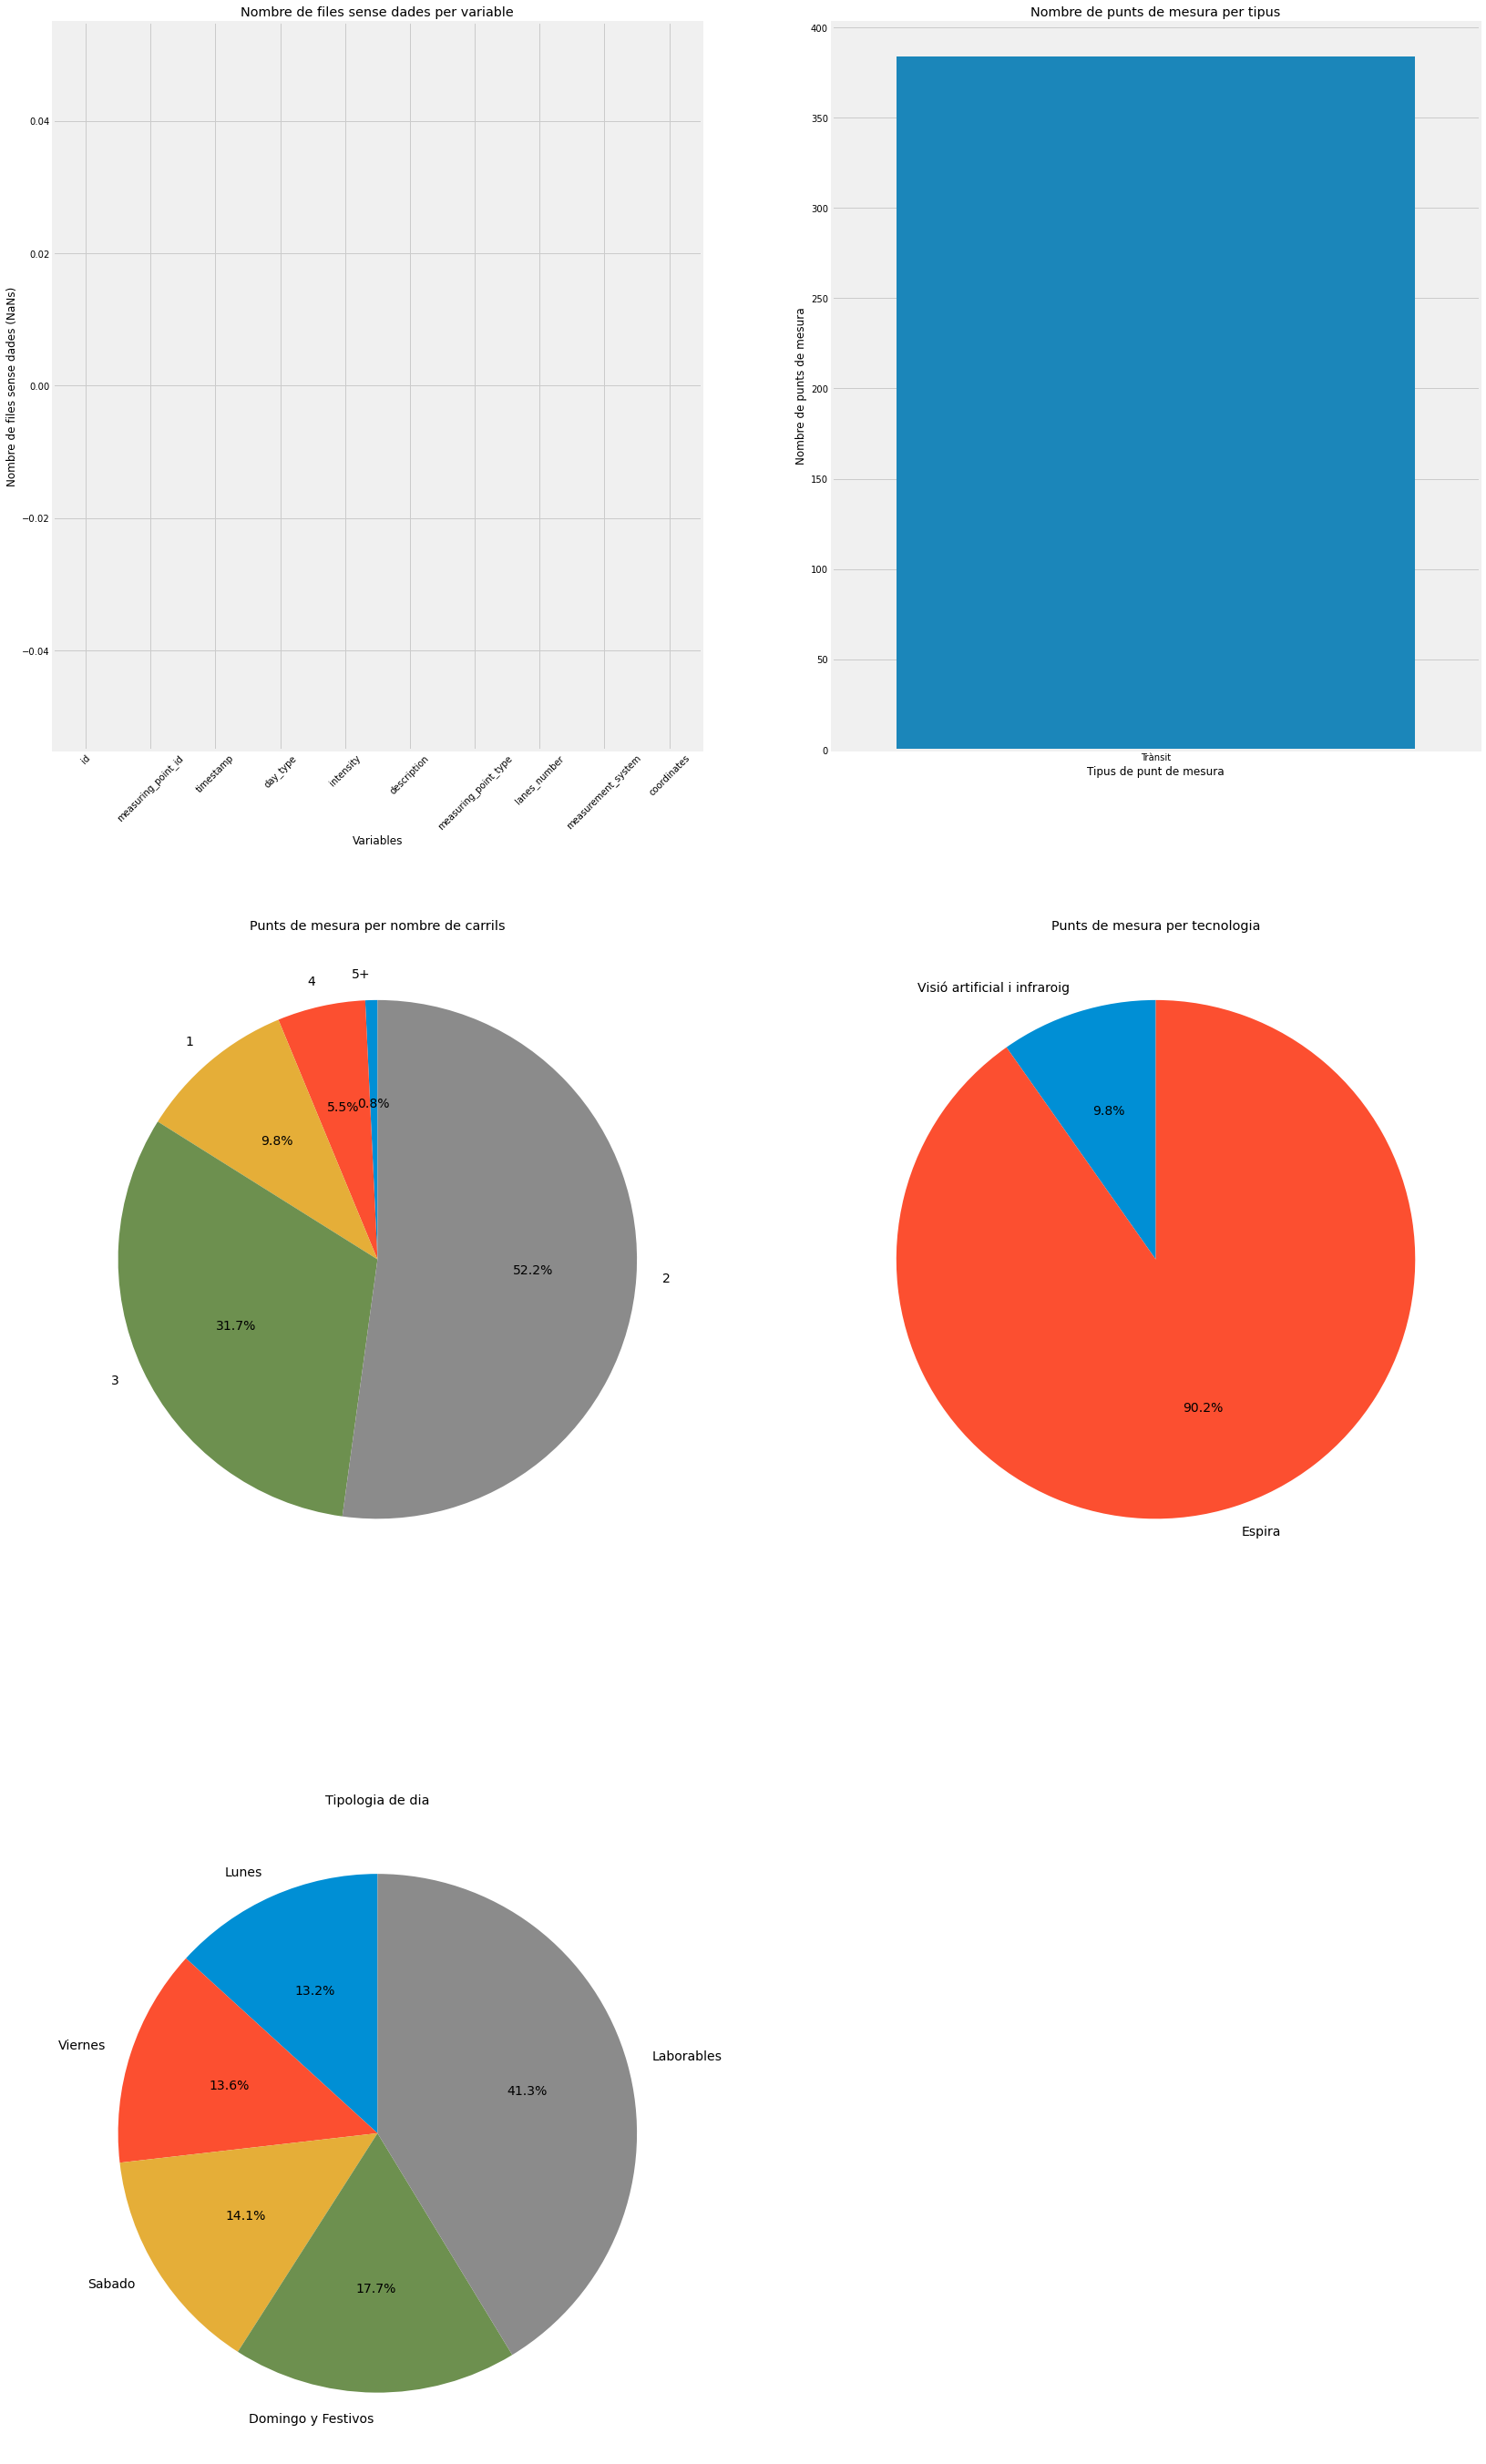

In [12]:
fig = plt.figure(figsize=(25, 50))

ax1 = fig.add_subplot(321)
_ = df \
    .isnull().sum() \
    .sort_values(ascending=False) \
    .plot(kind="bar", xlabel="Variables", rot=45, ax=ax1,
          ylabel="Nombre de files sense dades (NaNs)",
          title="Nombre de files sense dades per variable")

ax2 = fig.add_subplot(322)
_ = sns.barplot(
    x="measuring_point_type", y="measuring_point_id", 
    data=measuring_type_grouped_df, ax=ax2)
_ = ax2.set_title("Nombre de punts de mesura per tipus")
_ = ax2.set_xlabel("Tipus de punt de mesura")
_ = ax2.set_ylabel("Nombre de punts de mesura")

ax3 = fig.add_subplot(323)
title = "Punts de mesura per nombre de carrils"
visualizations.create_pie_chart_with_grouped_threshold(
    df, "lanes_number", grouped_label="5+", 
    ax=ax3, title=title, threshold=0.01)

ax4 = fig.add_subplot(324)
title = "Punts de mesura per tecnologia"
grouped_label = "Visió artificial i infraroig"
visualizations.create_pie_chart_with_grouped_threshold(
    df, "measurement_system", grouped_label=grouped_label, 
    ax=ax4, title=title, threshold=0.1)

ax5 = fig.add_subplot(325)
title = "Tipologia de dia"
visualizations.create_pie_chart_with_grouped_threshold(
    df, "day_type", ax=ax5, title=title, threshold=0.1)

### Ens centrem a analitzar un punt de mesura concret per un període de l'any:

- 1001
- AV. DIAGONAL - TORRE MELINA (Entrada)
- des de l'abril fins al juny

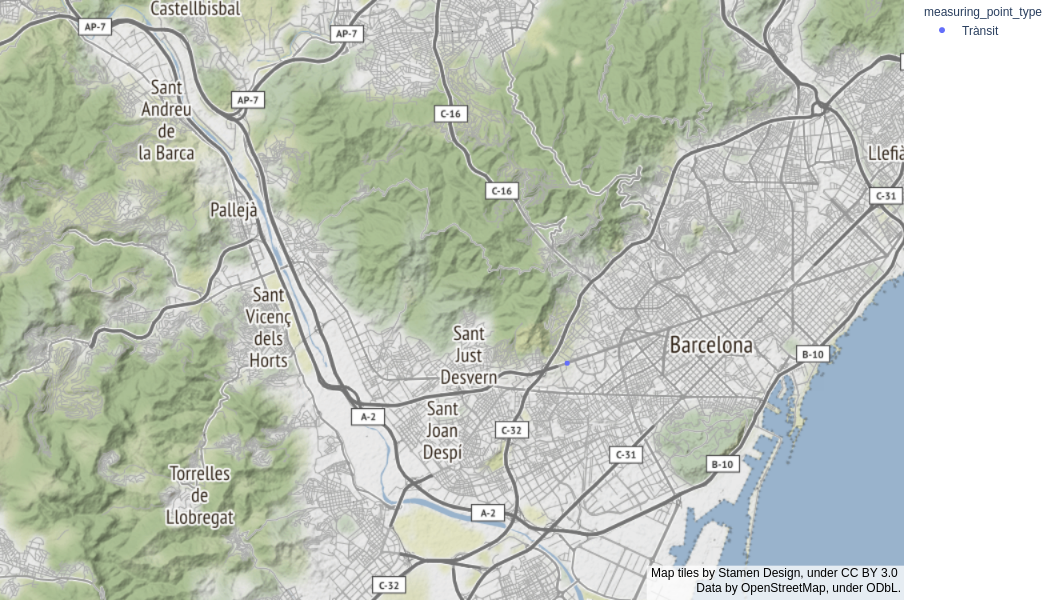

In [13]:
cond_selected_mp = measuring_points_df.measuring_point_id == selected_mp
visualizations.plot_measuring_points(
    measuring_points_df[cond_selected_mp].copy(), 
    coordinates_column='coordinates', 
    color_column='measuring_point_type')

In [14]:
cond_selected_mp = df.measuring_point_id == selected_mp
cond_timestamp_gte = df.timestamp >= '2019-04-08'
cond_timestamp_lte = df.timestamp <= '2019-07-01'

filter_conditions = \
    cond_selected_mp & cond_timestamp_gte & cond_timestamp_lte
mp_df = df[filter_conditions]

print(f"mp_df.shape: {mp_df.shape}\n")
mp_df.head()

mp_df.shape: (8049, 10)



id measuring_point_id           timestamp day_type  \
182713  1001-20190408000000               1001 2019-04-08 00:00:00    Lunes   
182714  1001-20190408001500               1001 2019-04-08 00:15:00    Lunes   
182715  1001-20190408003000               1001 2019-04-08 00:30:00    Lunes   
182716  1001-20190408004500               1001 2019-04-08 00:45:00    Lunes   
182717  1001-20190408010000               1001 2019-04-08 01:00:00    Lunes   

        intensity                            description measuring_point_type  \
182713        208  AV. DIAGONAL - TORRE MELINA (Entrada)              Trànsit   
182714        180  AV. DIAGONAL - TORRE MELINA (Entrada)              Trànsit   
182715        118  AV. DIAGONAL - TORRE MELINA (Entrada)              Trànsit   
182716        166  AV. DIAGONAL - TORRE MELINA (Entrada)              Trànsit   
182717         67  AV. DIAGONAL - TORRE MELINA (Entrada)              Trànsit   

        lanes_number measurement_system                        coordinates  
182713             3             Espira  41.3837355108734,2.10952517290599  
182714             3             Espira  41.3837355108734,2.10952517290599  
182715             3             Espira  41.3837355108734,2.10952517290599  
182716             3             Espira  41.3837355108734,2.10952517290599  
182717             3             Espira  41.3837355108734,2.10952517290599

Fem una gràfica per veure tot el periode de dades

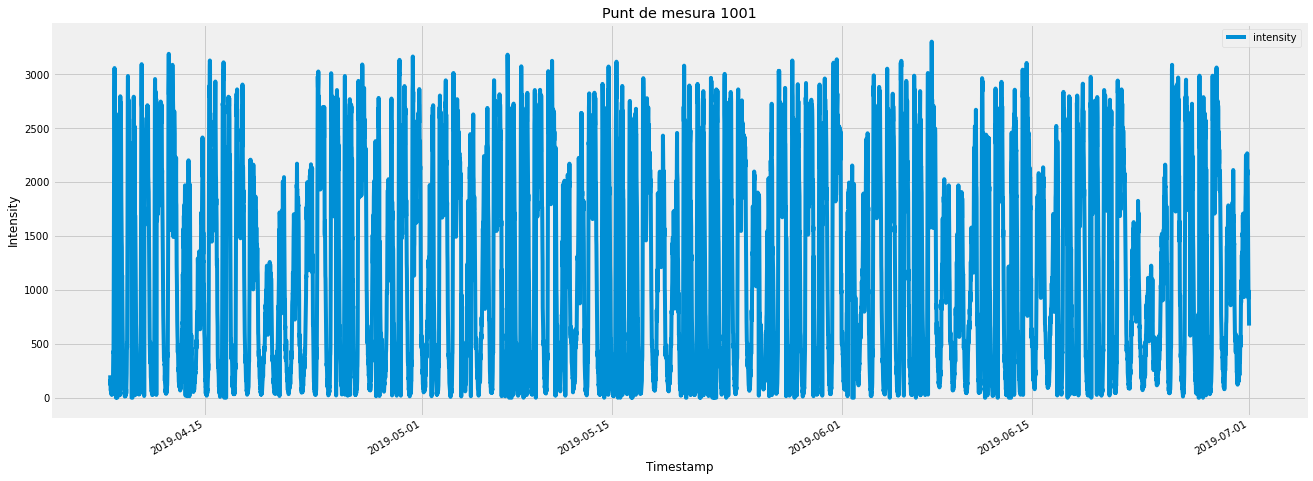

In [15]:
_ = mp_df \
    .plot(x='timestamp', y='intensity', figsize=(20, 8), 
          xlabel='Timestamp', ylabel='Intensity', title=f'Punt de mesura {selected_mp}')

Per veure les dades que ens falten, calcularem quantes files hem de tenir per cada dia.
Tenim dades de **cada 15 minuts**. Això vol dir que per cada hora tenim 4 files. Cada dia té 24 hores, per tant **24 x 4 = 96 files per cada dia**

In [16]:
rows_per_day = 96

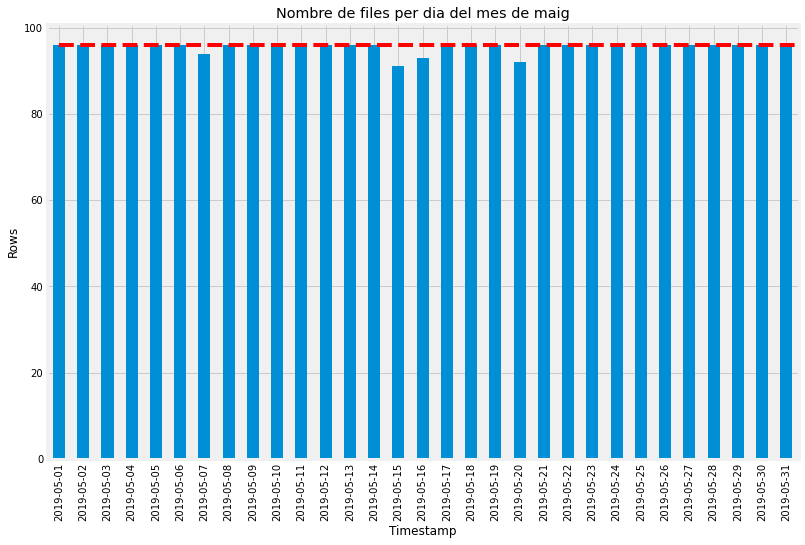

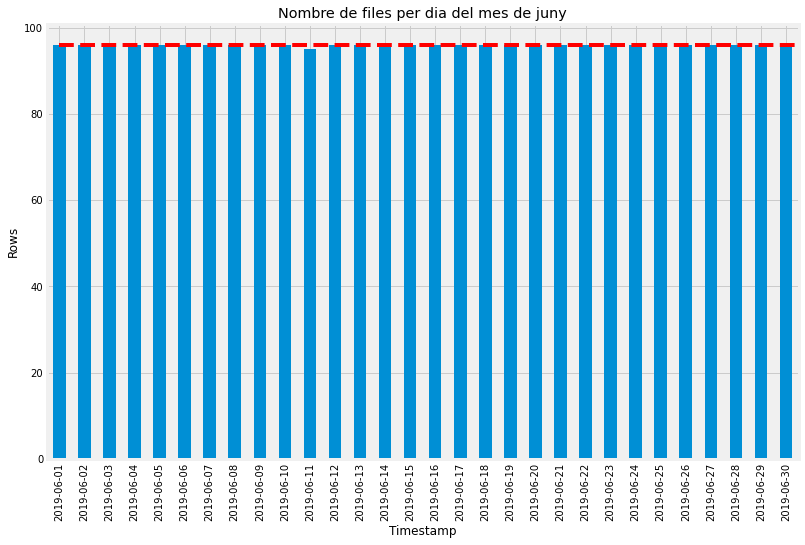

In [17]:
months = [
    (4, 'abril'),
    (5, 'maig'),
    (6, 'juny'),
]
for (month, label) in months:
    fig, ax = plt.subplots(figsize=(12, 8))
    cond_month = mp_df.timestamp.dt.month == month
    _ = mp_df[cond_month] \
        .groupby(mp_df.timestamp.dt.date) \
        .size() \
        .plot(kind='bar', xlabel='Timestamp', ylabel='Rows', 
              title=f'Nombre de files per dia del mes de {label}', ax=ax)

    # Adding line to correct rows number
    correct_rows_per_day = 96
    xmax = mp_df[cond_month].timestamp.dt.date.nunique()
    _ = ax.hlines(y=correct_rows_per_day, xmin=0, xmax=xmax, 
                  linestyle='--', color='red')

In [18]:
mp_df = mp_df \
    .set_index("timestamp") \
    .asfreq("15min")

In [19]:
print(f'Files sense dades: {mp_df.isnull().sum().id}')

Files sense dades: 16


In [20]:
mp_df[mp_df.id.isnull()].index.unique()

DatetimeIndex(['2019-04-23 06:00:00', '2019-05-07 14:00:00',
               '2019-05-07 14:15:00', '2019-05-15 13:45:00',
               '2019-05-15 14:00:00', '2019-05-15 14:15:00',
               '2019-05-15 14:30:00', '2019-05-15 14:45:00',
               '2019-05-16 10:30:00', '2019-05-16 12:00:00',
               '2019-05-16 12:15:00', '2019-05-20 10:45:00',
               '2019-05-20 11:00:00', '2019-05-20 11:30:00',
               '2019-05-20 11:45:00', '2019-06-11 12:45:00'],
              dtype='datetime64[ns]', name='timestamp', freq=None)

In [21]:
mp_df \
    .reset_index(inplace=True)

mp_df['hour'] = mp_df.timestamp.dt.hour
mp_df['date'] = mp_df.timestamp.dt.date
mp_df['month'] = mp_df.timestamp.dt.month

# Cleaning measuring point
mp_df['measuring_point_id'] = mp_df.measuring_point_id.fillna(selected_mp)

# Cleaning day_type
day_type_df = mp_df[['date', 'day_type']] \
    .drop_duplicates() \
    .dropna() \
    .reset_index(drop=True) \
    .rename(columns={'day_type': 'cleaned_day_type'})

mp_df = pd.merge(
    mp_df, day_type_df, how='left', on='date')

mp_df['day_type'] = mp_df \
    .day_type \
    .fillna(mp_df.cleaned_day_type)

Exemple de dies que falten dades
- 2019-04-23
- 2019-05-15

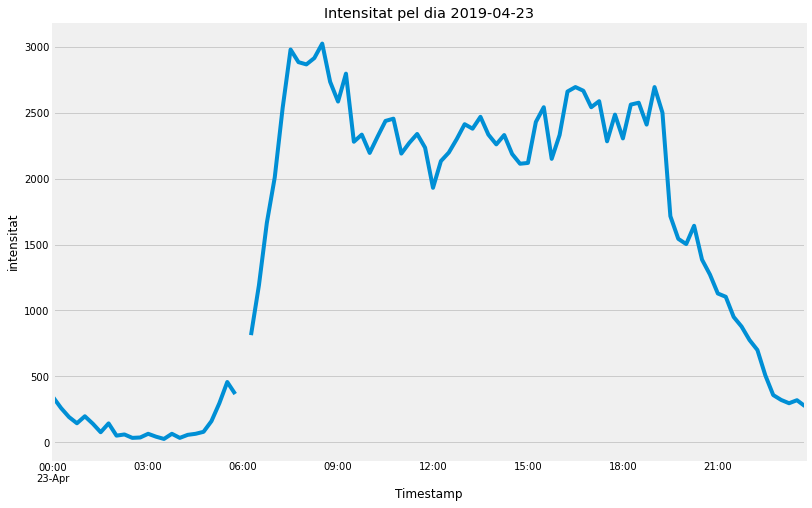

In [22]:
cond_missing_day = mp_df.date == datetime(2019, 4, 23).date()
_ = mp_df[cond_missing_day] \
    .plot(x='timestamp', y='intensity', figsize=(12, 8), legend=False,  
          xlabel='Timestamp', ylabel='intensitat', title='Intensitat pel dia 2019-04-23')

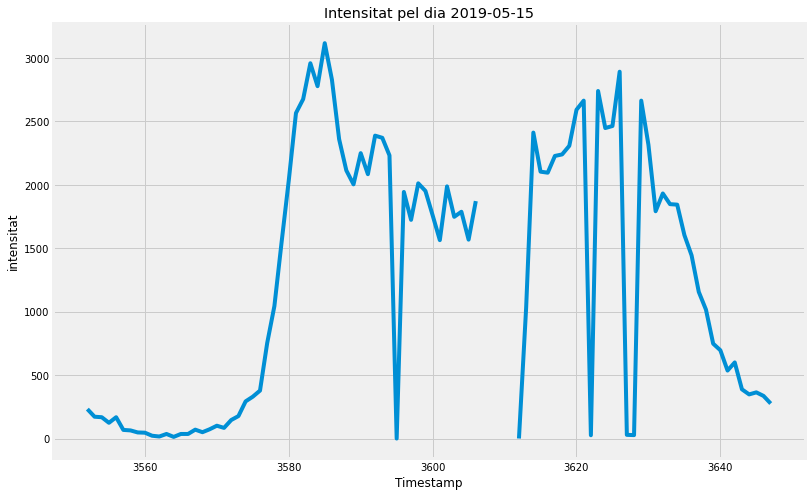

In [23]:
cond_missing_day = mp_df.date == datetime(2019, 5, 15).date()
_ = mp_df[cond_missing_day] \
    .plot(y='intensity', figsize=(12, 8), legend=False, xlabel='Timestamp',
          ylabel='intensitat', title='Intensitat pel dia 2019-05-15')

Per cada un dels dies que falten dades, calcularem la mitjana per:
- hora 
- tipologia de dia

In [24]:
cond_selected_mp = df.measuring_point_id == '1001'
history_mp_df = df[cond_selected_mp].copy()
history_mp_df['hour'] = history_mp_df.timestamp.dt.hour

means_df = pd.DataFrame()
for date in mp_df[mp_df.id.isnull()].timestamp.dt.date:
    start_date = pd.Timestamp(date - timedelta(days=31))
    end_date = pd.Timestamp(date - timedelta(days=1))
    
    # Calculem la mitjana per tipus de dia i hora dels 30 dies anteriors
    cond_timestamp_gte = history_mp_df.timestamp >= start_date
    cond_timestamp_lte = history_mp_df.timestamp <= end_date
    iter_df = history_mp_df[cond_timestamp_gte & cond_timestamp_lte]
    
    result_df = iter_df \
        .groupby(['day_type', 'hour']) \
        .agg({'intensity': np.mean}) \
        .reset_index() \
        .rename(columns={'intensity': 'mean_intensity', 'timestamp': 'date'})
    result_df['date'] = date
    
    means_df = pd.concat([means_df, result_df], ignore_index=True)

Per cada registre sense dades, ho canviem per la mitjana

In [25]:
merge_columns = [
    'date',
    'day_type', 
    'hour'
]
mp_df = pd.merge(
    mp_df, means_df, how='left', on=merge_columns) \
    .drop_duplicates()

mp_df['intensity'] = mp_df \
    .intensity \
    .fillna(mp_df.mean_intensity)

assert mp_df.intensity.isnull().sum() == 0

In [26]:
mp_df = mp_df \
    .set_index('timestamp') \
    .asfreq('15min')

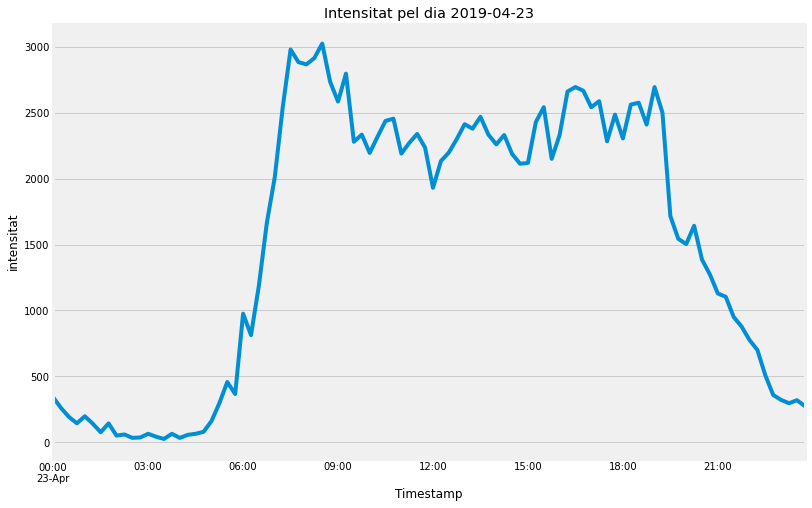

In [27]:
sample_df = mp_df.loc['2019-04-23', 'intensity'].copy()

_ = sample_df \
    .plot(y='intensity', figsize=(12, 8), 
          xlabel='Timestamp', ylabel='intensitat', title='Intensitat pel dia 2019-04-23')

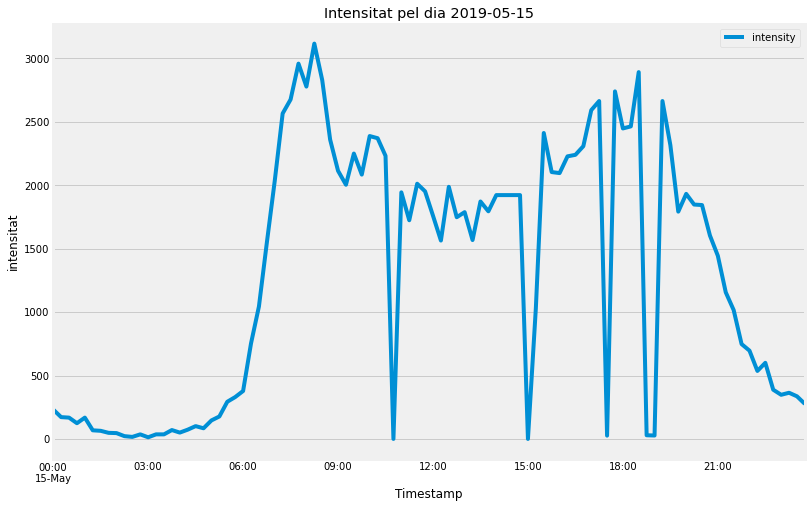

In [28]:
cond_missing_day = mp_df.date == datetime(2019, 5, 15).date()
_ = mp_df[cond_missing_day] \
    .plot(y='intensity', figsize=(12, 8), 
          xlabel='Timestamp', ylabel='intensitat', title='Intensitat pel dia 2019-05-15')

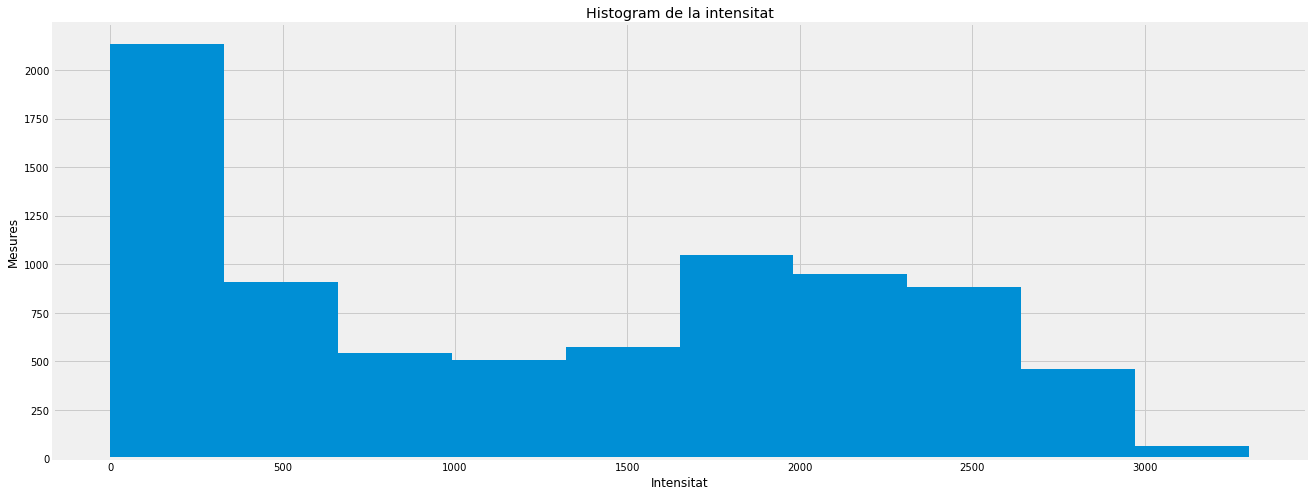

In [29]:
ax = mp_df.intensity.hist(figsize=(20, 8))
_ = ax.set_xlabel('Intensitat')
_ = ax.set_ylabel('Mesures')
_ = ax.set_title('Histogram de la intensitat')

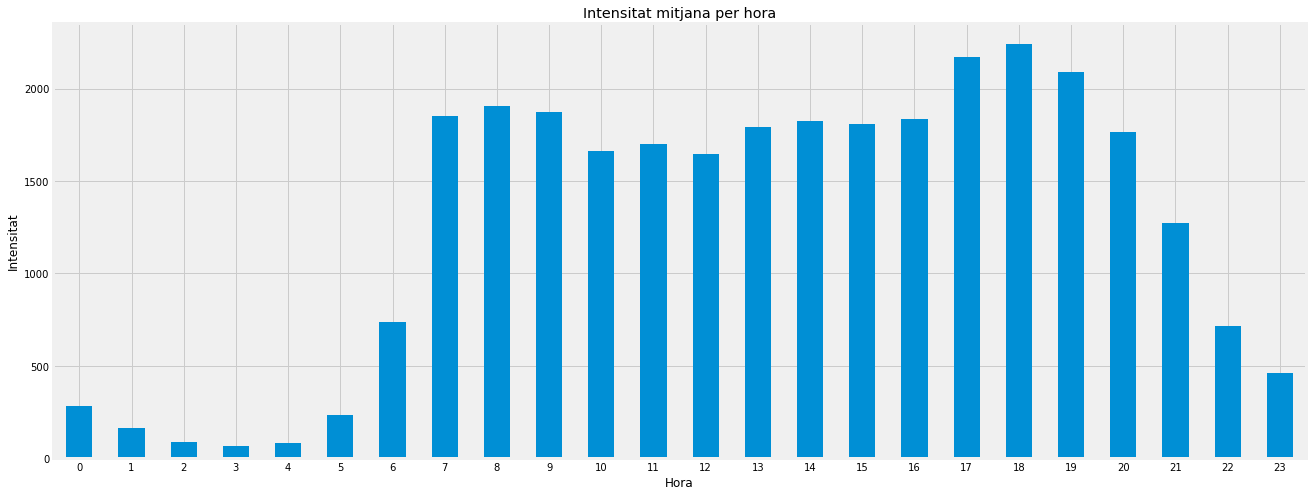

In [30]:
mean_per_hour = mp_df \
    .groupby('hour') \
    .agg({'intensity': np.mean})

_ = mean_per_hour \
    .plot(kind='bar', rot=0, figsize=(20, 8), xlabel='Hora', legend=None, 
          ylabel='Intensitat', title='Intensitat mitjana per hora')

In [31]:
grouped_df = mp_df \
    .groupby(['hour', 'day_type']) \
    .agg({'intensity': np.mean}) \
    .reset_index()

grouped = grouped_df.groupby('day_type')

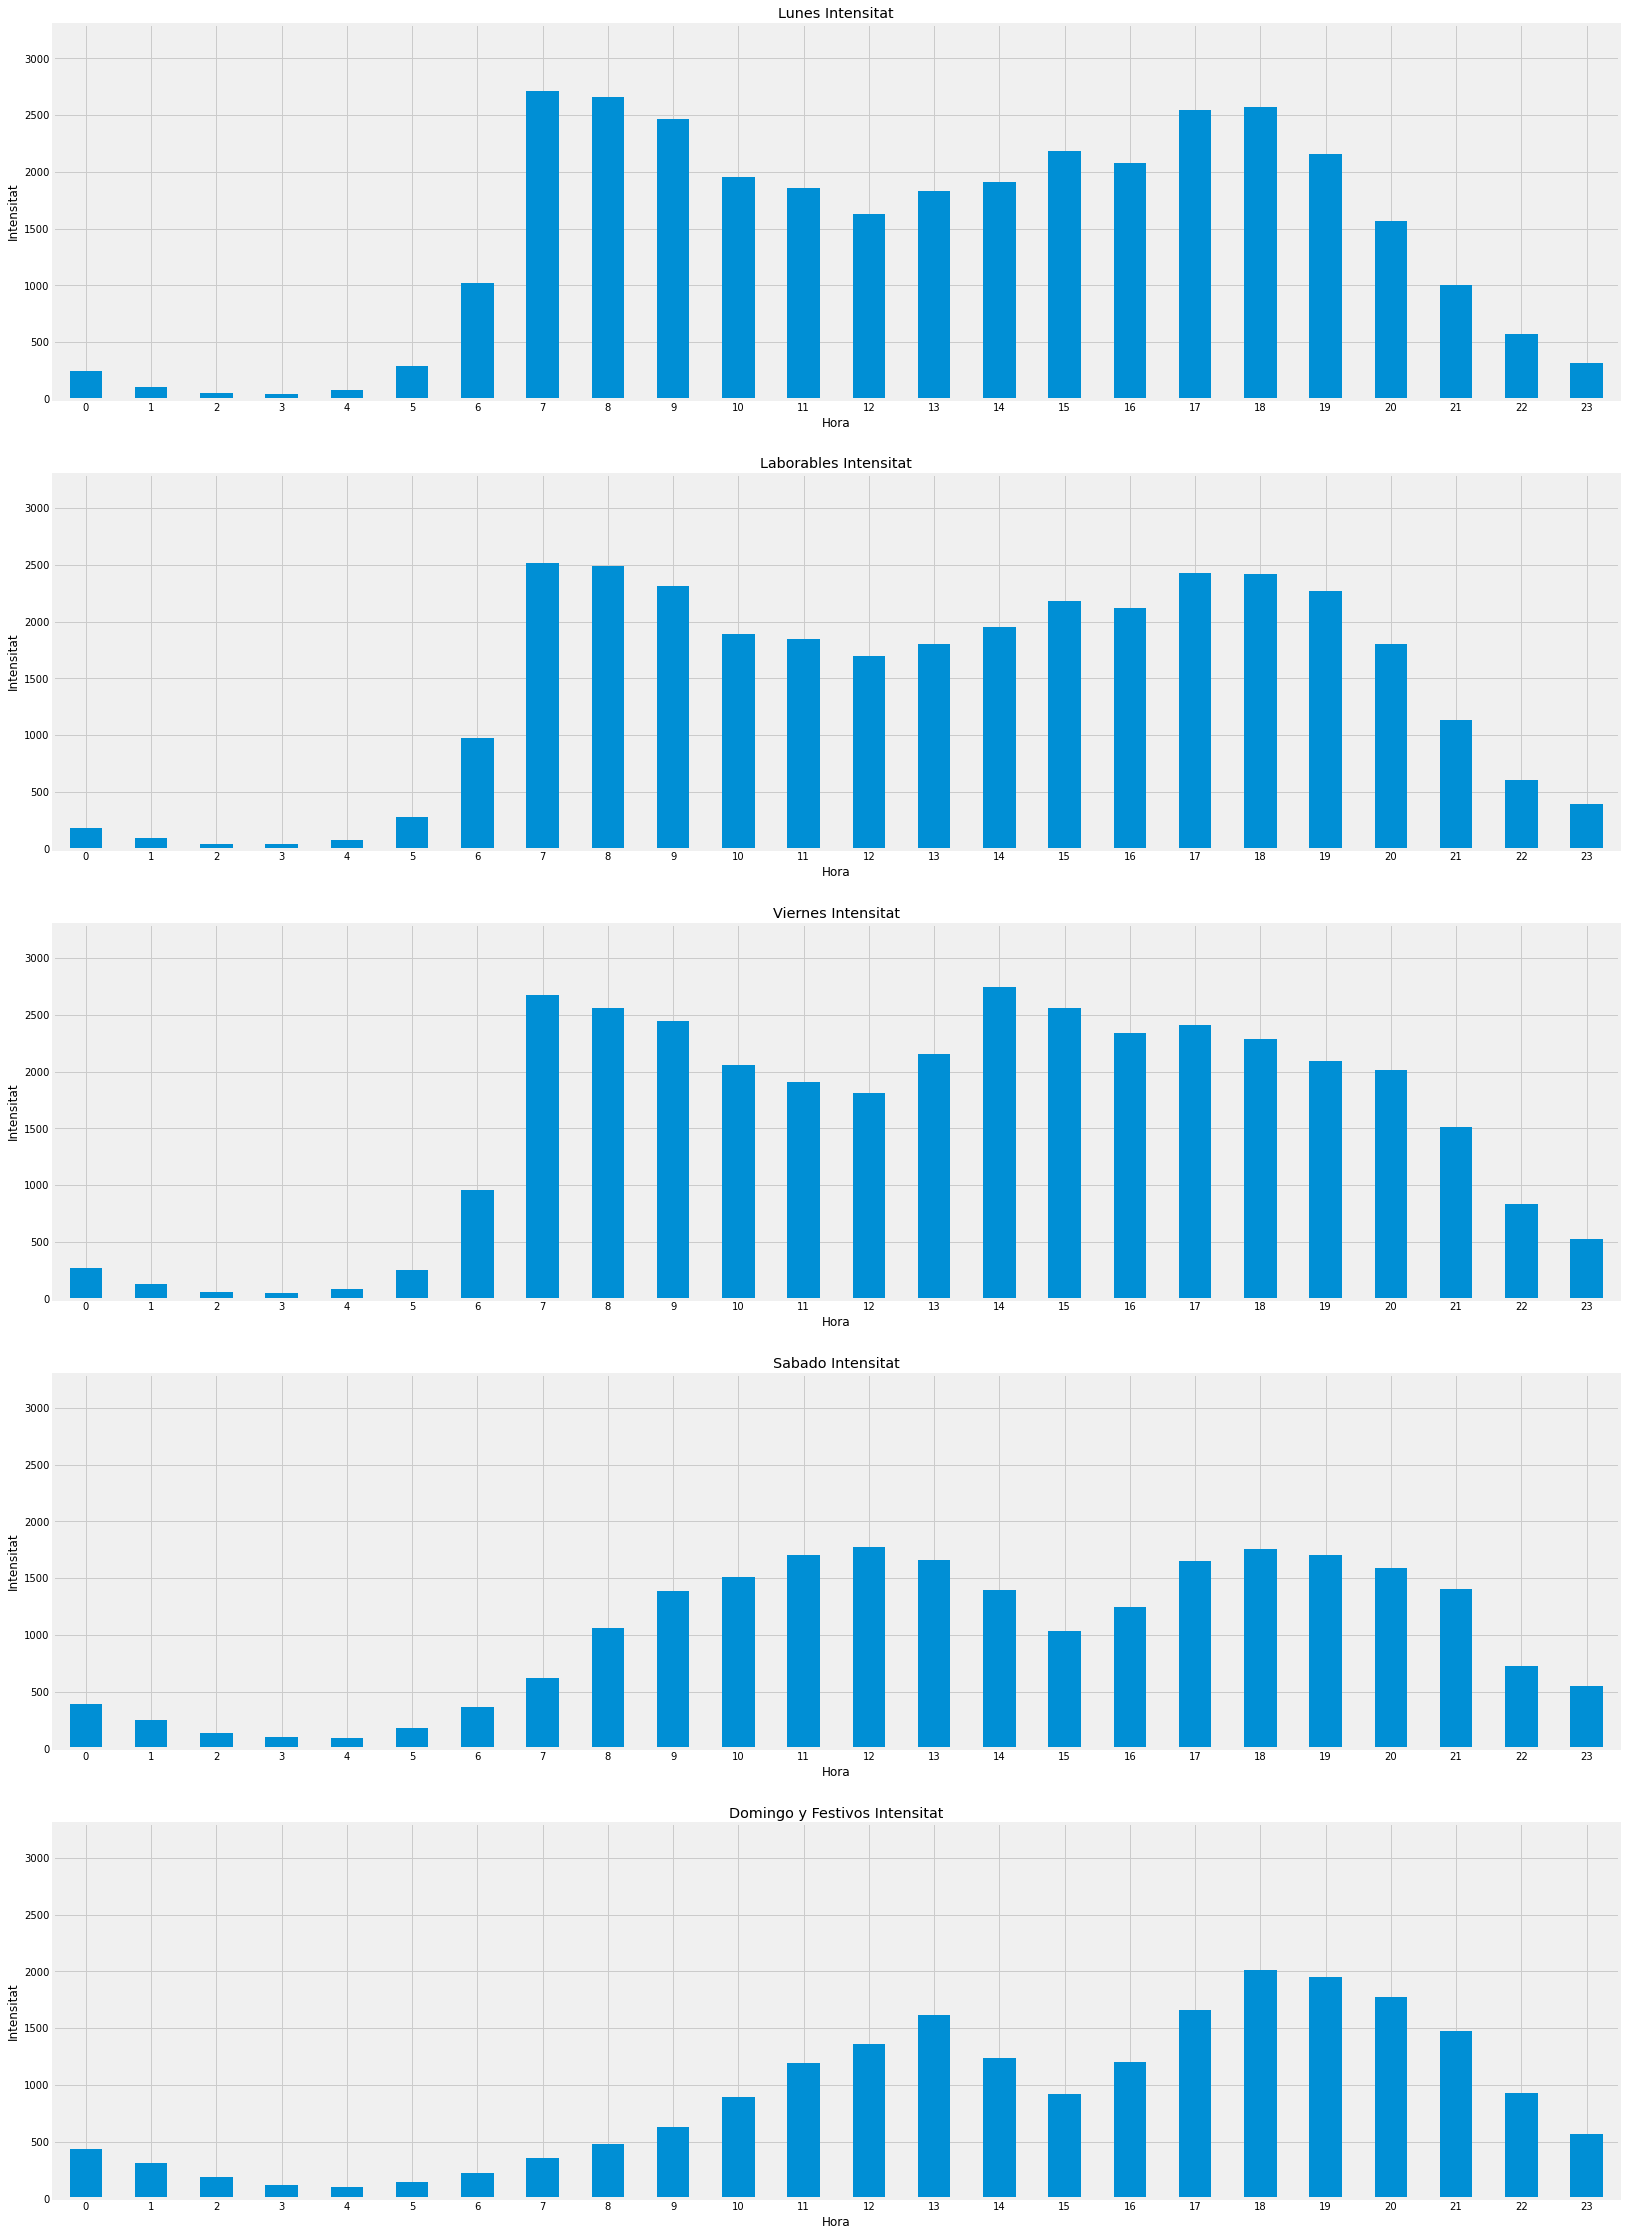

In [32]:
grouped_df = mp_df \
    .groupby(['hour', 'day_type']) \
    .agg({'intensity': np.mean}) \
    .reset_index()

groups = [
    'Lunes',
    'Laborables',
    'Viernes',
    'Sabado',
    'Domingo y Festivos',
]
grouped = grouped_df.groupby('day_type')

max_intensity = mp_df.intensity.max()

fig = plt.figure(figsize=(25, 40))
for i, day_type in enumerate(groups, start=1):
    ax = fig.add_subplot(5, 1, i)
    
    iter_df = grouped.get_group(day_type)
    
    _ = iter_df \
        .plot(kind='bar', ax=ax, x='hour', y='intensity', title=f'{day_type} Intensitat', 
              xlabel='Hora', ylabel='Intensitat', rot=0, ylim=(0, max_intensity), legend=None)

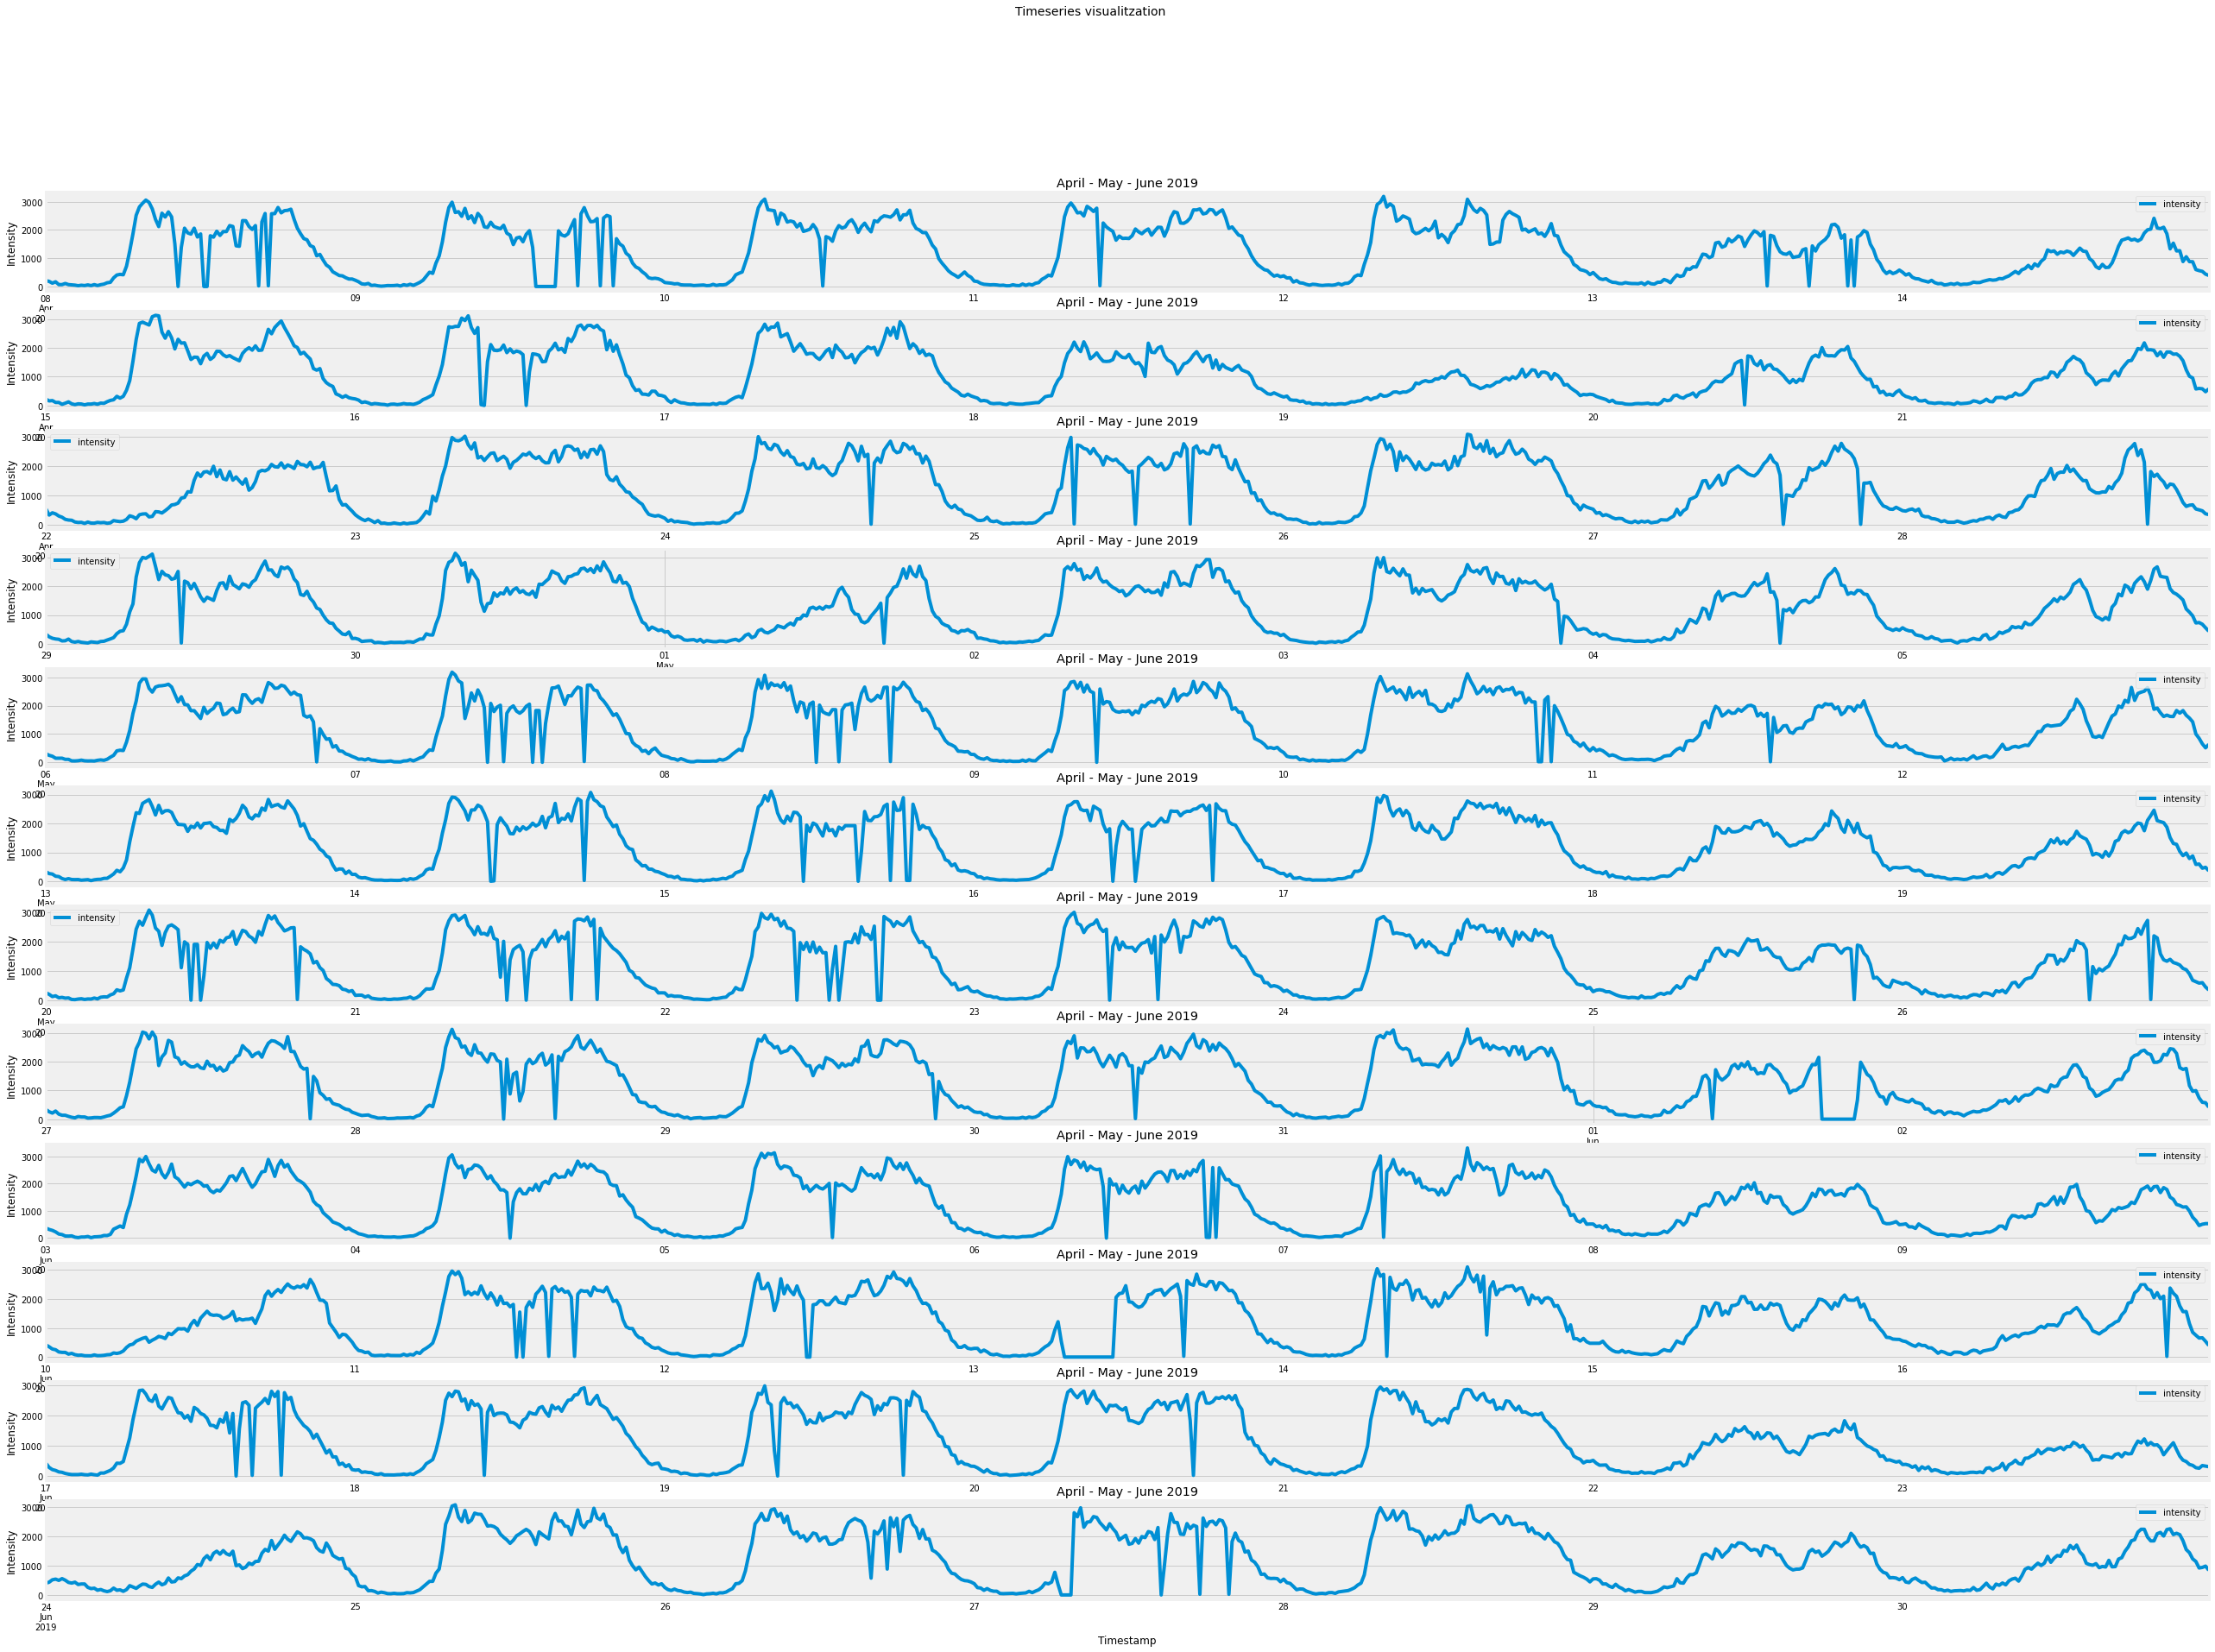

In [33]:
dates = [
    ('2019-04-08', '2019-04-14'),
    ('2019-04-15', '2019-04-21'),
    ('2019-04-22', '2019-04-28'),
    ('2019-04-29', '2019-05-05'),
    ('2019-05-06', '2019-05-12'),
    ('2019-05-13', '2019-05-19'),
    ('2019-05-20', '2019-05-26'),
    ('2019-05-27', '2019-06-02'),
    ('2019-06-03', '2019-06-09'),
    ('2019-06-10', '2019-06-16'),
    ('2019-06-17', '2019-06-23'),
    ('2019-06-24', '2019-06-30'),
]

fig = plt.figure(figsize=(40, 30))
fig.suptitle("Timeseries visualitzation", fontsize=14)

for i, (start_date, end_date) in enumerate(dates, start=1):
    iter_df = mp_df.loc[start_date:end_date, ['intensity']]
        
    ax = fig.add_subplot(len(dates), 1, i)
    iter_df \
        .plot(xlabel="Timestamp", ylabel='Intensity', title='April - May - June 2019', ax=ax)

Ho passem a nivell horari, calculant la mitjana de la intensitat per cada hora

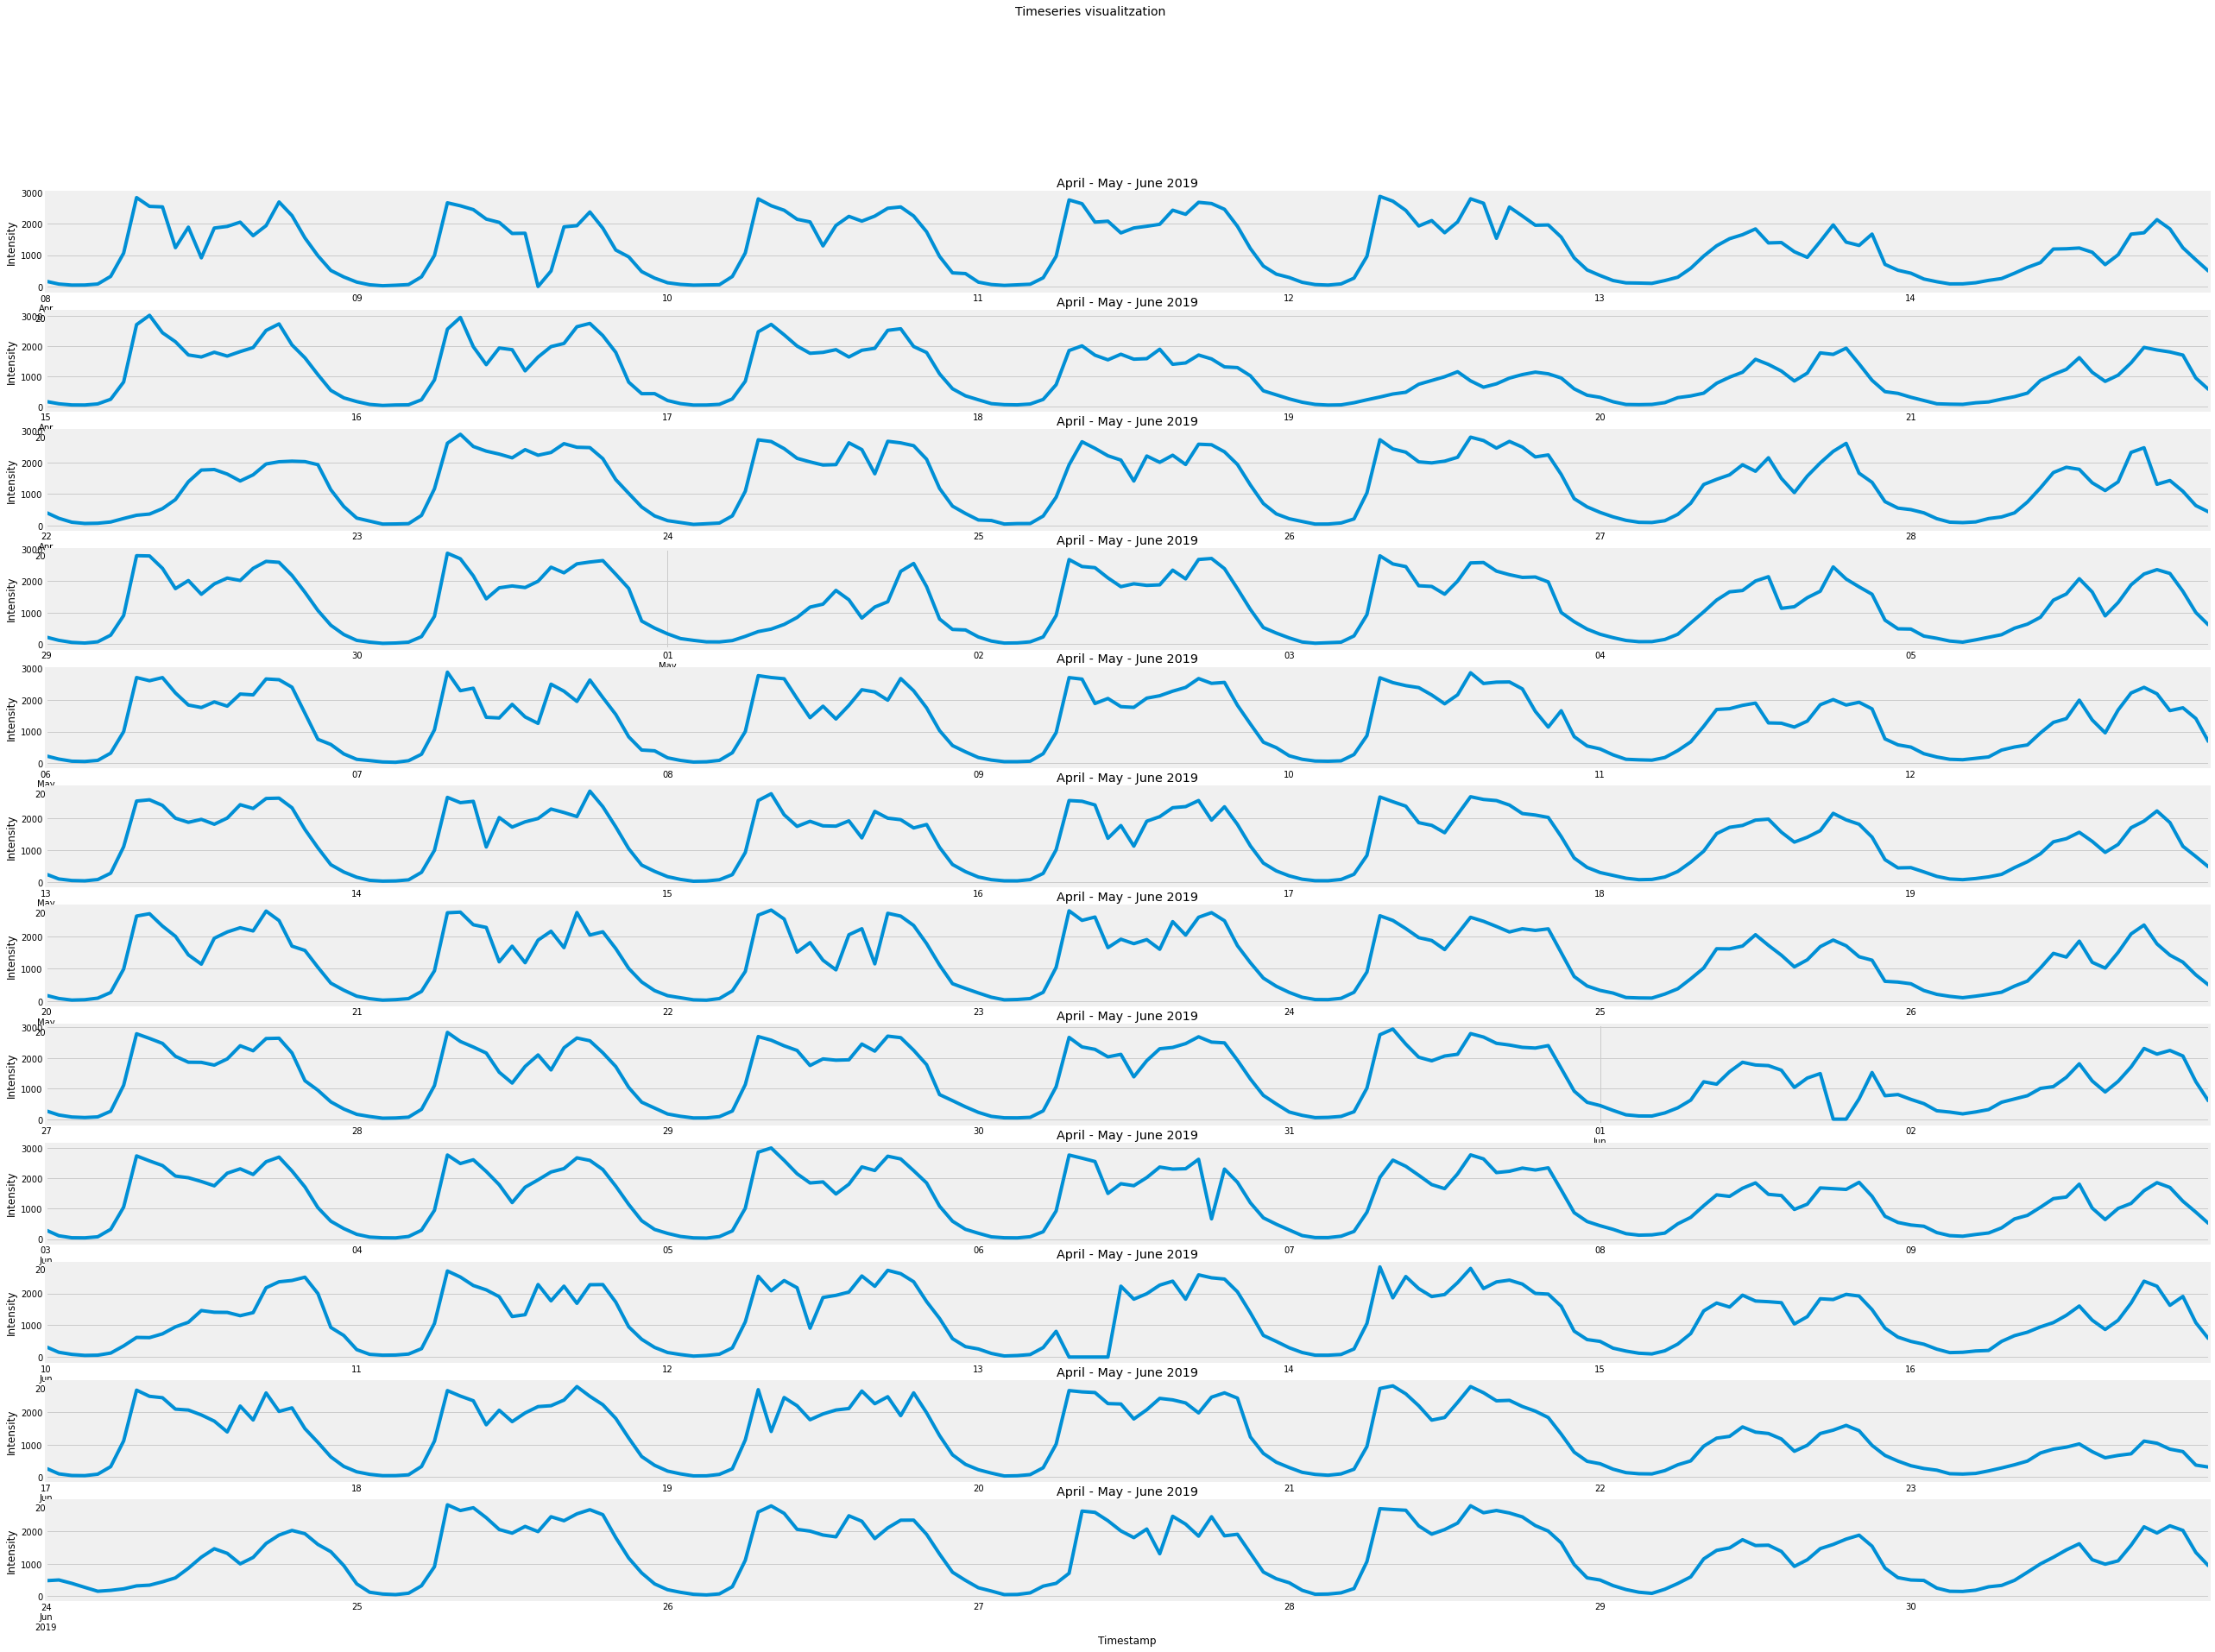

In [34]:
hourly_timeseries = mp_df['intensity'] \
    .resample('H') \
    .mean()

fig = plt.figure(figsize=(40, 30))
fig.suptitle("Timeseries visualitzation", fontsize=14)

for i, (start_date, end_date) in enumerate(dates, start=1):
    iter_s = hourly_timeseries[start_date:end_date]
        
    ax = fig.add_subplot(len(dates), 1, i)
    iter_s \
        .plot(xlabel="Timestamp", ylabel='Intensity', title='April - May - June 2019', ax=ax)

Creem el dataset final on tindrem la intensitat i el one hot encoding per cada dia

In [35]:
hourly_timeseries_df = hourly_timeseries \
    .reset_index()

hourly_timeseries_df['date'] = hourly_timeseries_df.timestamp.dt.date

hourly_timeseries_df = pd.merge(
    hourly_timeseries_df, day_type_df, how='left', on='date')

hourly_timeseries_df = hourly_timeseries_df \
    .rename(columns={'cleaned_day_type': 'day_type'}) \
    .drop(columns=['date']) \
    .set_index('timestamp') \
    .asfreq('H')

hourly_timeseries_df.tail()

intensity            day_type
timestamp                                         
2019-06-30 20:00:00    2167.00  Domingo y Festivos
2019-06-30 21:00:00    2026.00  Domingo y Festivos
2019-06-30 22:00:00    1346.25  Domingo y Festivos
2019-06-30 23:00:00     925.25  Domingo y Festivos
2019-07-01 00:00:00     669.00               Lunes

Creem el one hot encoding de les columnes

In [36]:
ohe_day_type_df = pd.get_dummies(
    hourly_timeseries_df.day_type)

hourly_timeseries_df = pd.concat(
    [hourly_timeseries_df, ohe_day_type_df], axis=1)

columns_mapping = {
    'Domingo y Festivos': 'sunday_holidays',
    'Laborables': 'tuesday_thursday',
    'Lunes': 'monday', 
    'Sabado': 'saturday',
    'Viernes': 'friday'
}

hourly_timeseries_df = hourly_timeseries_df \
    .drop(columns=['day_type']) \
    .rename(columns=columns_mapping)

hourly_timeseries_df['day_of_week'] = hourly_timeseries_df.index.dayofweek

cond_holiday = hourly_timeseries_df.sunday_holidays
cond_sunday = hourly_timeseries_df.day_of_week == 6

hourly_timeseries_df['holiday'] = 0
hourly_timeseries_df.loc[cond_holiday & ~cond_sunday, ['holiday']] = 1

hourly_timeseries_df.drop(columns=['day_of_week'], inplace=True)

hourly_timeseries_df.tail(10)

intensity  sunday_holidays  tuesday_thursday  monday  \
timestamp                                                                   
2019-06-30 15:00:00     984.75                1                 0       0   
2019-06-30 16:00:00    1087.00                1                 0       0   
2019-06-30 17:00:00    1567.50                1                 0       0   
2019-06-30 18:00:00    2136.25                1                 0       0   
2019-06-30 19:00:00    1945.75                1                 0       0   
2019-06-30 20:00:00    2167.00                1                 0       0   
2019-06-30 21:00:00    2026.00                1                 0       0   
2019-06-30 22:00:00    1346.25                1                 0       0   
2019-06-30 23:00:00     925.25                1                 0       0   
2019-07-01 00:00:00     669.00                0                 0       1   

                     saturday  friday  holiday  
timestamp                                       
2019-06-30 15:00:00         0       0        0  
2019-06-30 16:00:00         0       0        0  
2019-06-30 17:00:00         0       0        0  
2019-06-30 18:00:00         0       0        0  
2019-06-30 19:00:00         0       0        0  
2019-06-30 20:00:00         0       0        0  
2019-06-30 21:00:00         0       0        0  
2019-06-30 22:00:00         0       0        0  
2019-06-30 23:00:00         0       0        0  
2019-07-01 00:00:00         0       0        0

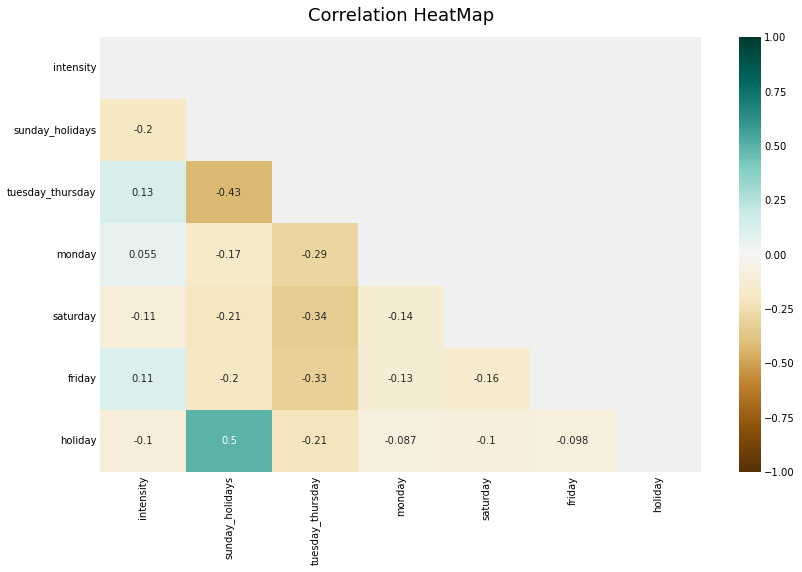

In [37]:
visualizations.plot_correlation_heat_map(
    hourly_timeseries_df, title='Correlation HeatMap', fig_size=(12, 8))

## Fase 3: Models

### 3.1 Separació train - test

#### Train:
- Setmana 1: 2019-04-01 to 2019-04-07
- Setmana 2: 2019-04-08 to 2019-04-14
- Setmana 3: 2019-04-15 to 2019-04-21
- Setmana 4: 2019-04-22 to 2019-04-28
- Setmana 5: 2019-04-26 to 2019-05-05
- Setmana 6: 2019-05-06 to 2019-05-12
- Setmana 7: 2019-05-13 to 2019-05-19

#### Test
- Setmana 8: 2019-05-20 to 2019-05-26

In [38]:
train = hourly_timeseries_df.loc['2019-04-01':'2019-05-19', 'intensity']

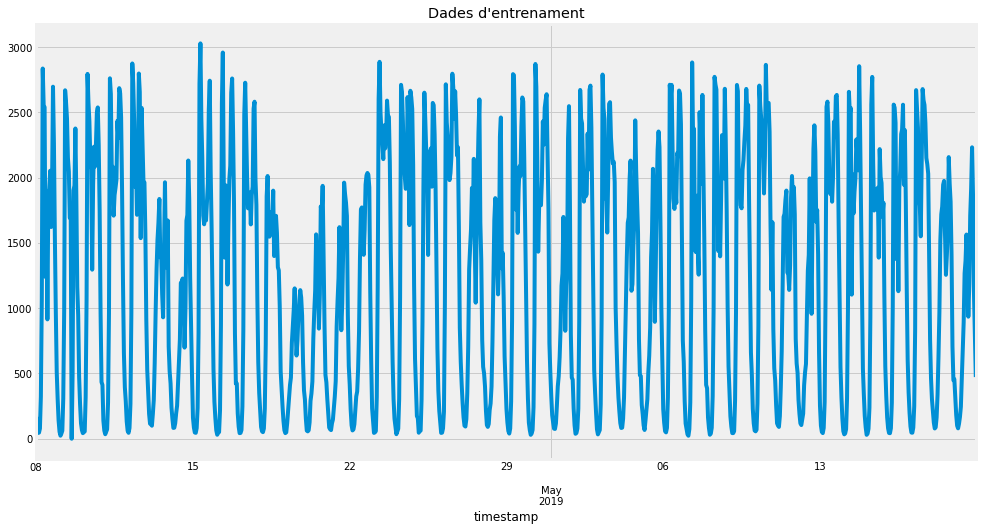

In [39]:
_ = train.plot(figsize=(15, 8), title="Dades d'entrenament")

In [40]:
test = hourly_timeseries_df.loc['2019-05-20':'2019-05-26', 'intensity']

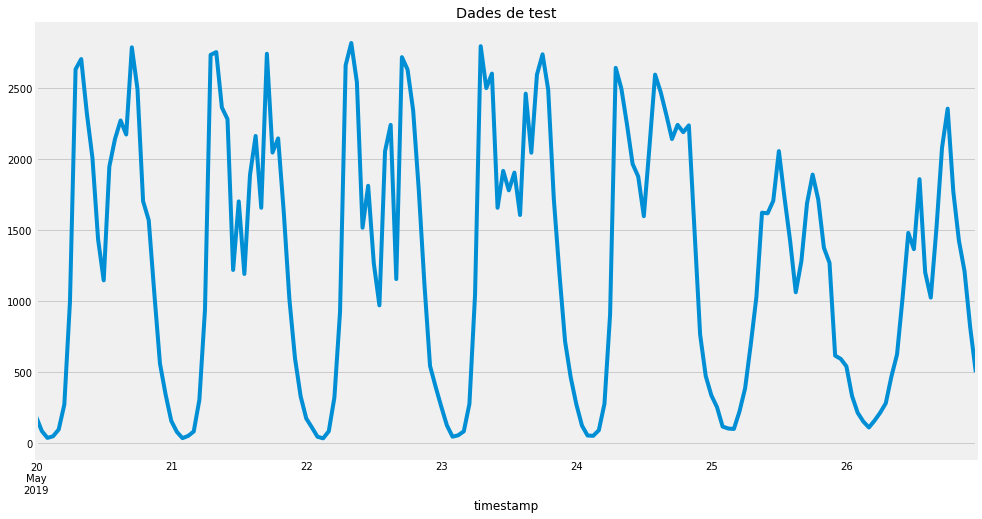

In [41]:
_ = test.plot(figsize=(15, 8), title="Dades de test")

### 3.2 Entrenaments dels model

#### Experiment 1: provem una estacionaritat diària (24 files)

- Intensitat com a variable a predir
- Tipologia de dia com a variables exògenes

In [42]:
exogen_columns = [
    'monday',
    'tuesday_thursday',
    'friday',
    'saturday',
    'sunday_holidays',
]

exog_train = hourly_timeseries_df.loc['2019-04-01':'2019-05-19', exogen_columns].values
train_size = train.shape[0]

exog_test = hourly_timeseries_df.loc['2019-05-20':'2019-05-26', exogen_columns].values
test_size = test.shape[0]

In [43]:
model = SARIMAX(train, 
    order=(1, 0, 2),
    seasonal_order=(1, 0, 2, 24),
    exog=exog_train,
    enforce_invertibility=False,
    enforce_stationarity=False,
    freq=train.index.inferred_freq)

sarima_fit = model.fit(disp=0)

### Predicció

In [44]:
metrics = {}

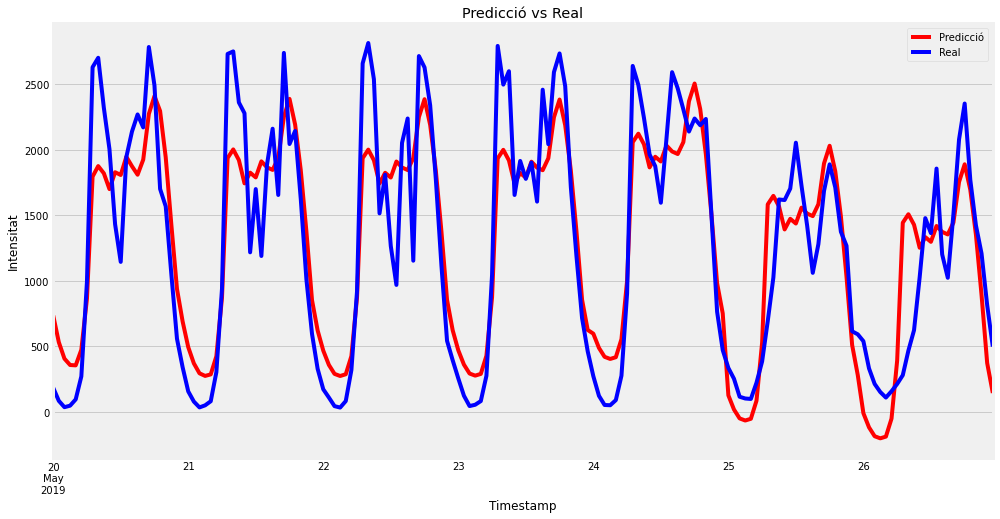

In [45]:
forecast = sarima_fit \
    .forecast(steps=test_size, exog=exog_test)

daily_predictions_df = pd.DataFrame(forecast) \
    .rename(columns={'predicted_mean': 'daily_predictions'})
daily_predictions_df['target'] = test

ax = daily_predictions_df \
    .plot(figsize=(15, 8), color=['red', 'blue'], title='Predicció vs Real', 
          xlabel='Timestamp', ylabel='Intensitat')

_ = ax.legend(['Predicció', 'Real'])

In [46]:
rmse = mean_squared_error(test, daily_predictions_df.daily_predictions, squared=False)
print(f'Root mean squared error {rmse}')

metrics['daily'] = rmse

Root mean squared error 390.6965962095595


###  Experiment 2: Estacionaritat setmanal (168 files)

- Intensitat com a variable a predir
- variable 'dummy' per indicar si es festiu o no com a variable exògena

In [47]:
exogen_columns = [
    'holiday',
]

exog_train = hourly_timeseries_df.loc['2019-04-01':'2019-05-19', exogen_columns].values
train_size = train.shape[0]

exog_test = hourly_timeseries_df.loc['2019-05-20':'2019-05-26', exogen_columns].values
test_size = test.shape[0]

In [48]:
model = SARIMAX(train, 
    order=(2, 0, 1),
    seasonal_order=(0, 1, 0, 168),
    exog=exog_train,
    enforce_invertibility=False,
    enforce_stationarity=False,
    freq=train.index.inferred_freq)

sarima_fit = model.fit(disp=0)

### Predicció

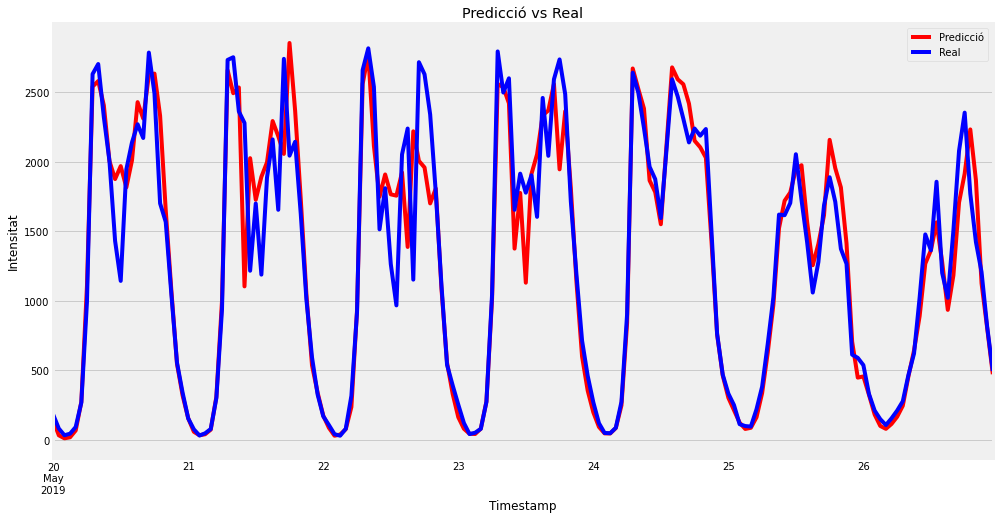

In [49]:
forecast = sarima_fit \
    .forecast(steps=test_size, exog=exog_test)

weekly_predictions_df = pd.DataFrame(forecast) \
    .rename(columns={'predicted_mean': 'weekly_predictions'})
weekly_predictions_df['target'] = test

ax = weekly_predictions_df \
    .plot(figsize=(15, 8), color=['red', 'blue'], title='Predicció vs Real', 
          xlabel='Timestamp', ylabel='Intensitat')

_ = ax.legend(['Predicció', 'Real'])

In [50]:
rmse = mean_squared_error(test, weekly_predictions_df.weekly_predictions, squared=False)
print(f'Root mean squared error {rmse}')

metrics['weekly'] = rmse

Root mean squared error 283.1272974358278


### 3.3 Avaluació dels models

In [51]:
metrics_df = pd.DataFrame(metrics, index=[0]) \
    .transpose()

metrics_df.index = ['Diari', 'Setmanal']

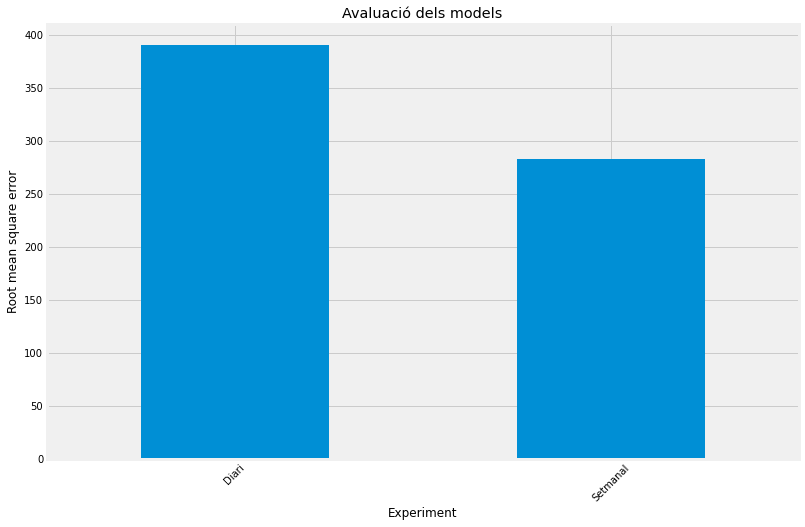

In [52]:
_ = metrics_df \
    .plot(kind='bar', legend=False, figsize=(12, 8), rot=45, 
          xlabel='Experiment', ylabel='Root mean square error', title='Avaluació dels models')

In [53]:
hourly_timeseries_df.intensity.describe()

count    2017.000000
mean     1262.054605
std       904.998354
min         0.000000
25%       319.750000
50%      1262.250000
75%      2052.000000
max      3027.750000
Name: intensity, dtype: float64

#### Comparació de les prediccions

In [54]:
predictions_df = pd.concat(
    [daily_predictions_df.drop(columns=['target']), weekly_predictions_df], axis=1)

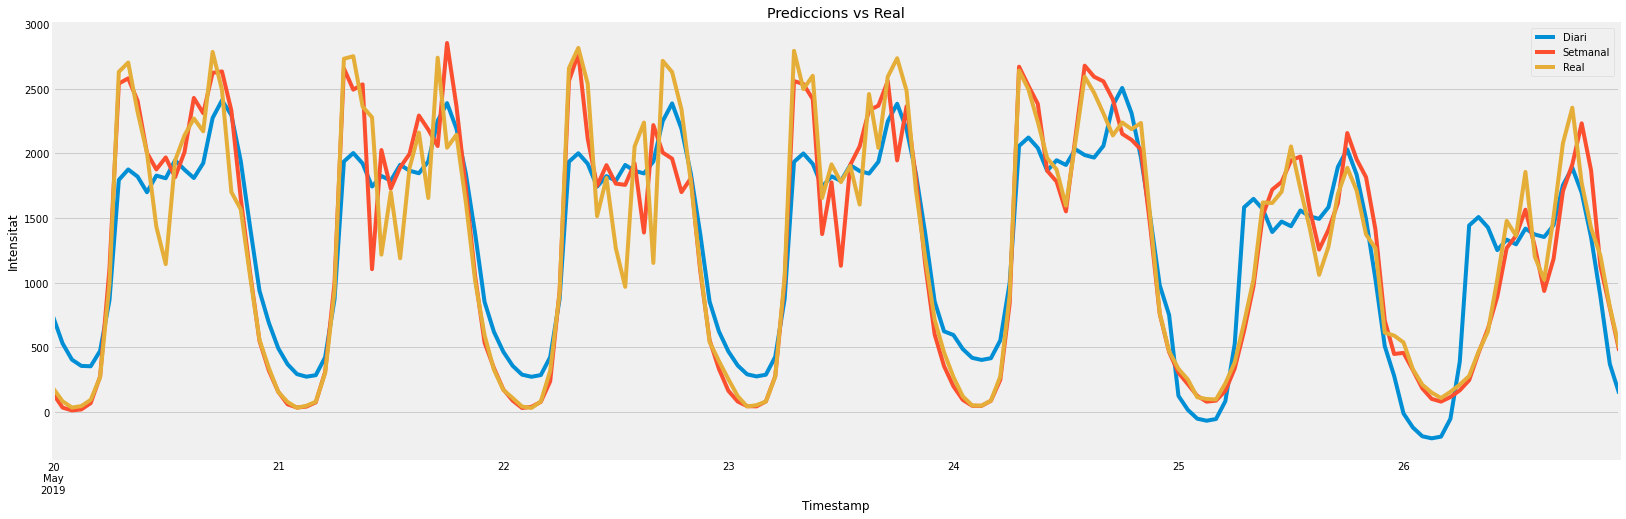

In [55]:
ax = predictions_df \
    .plot(figsize=(25, 8), xlabel='Timestamp', ylabel='Intensitat', 
          title='Prediccions vs Real')

_ = ax.legend(['Diari', 'Setmanal', 'Real'])